# Задание 1

In [90]:
from mplfinance.original_flavor import candlestick_ohlc # pip install --upgrade mplfinance
import yfinance as yf  # pip install yfinance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose


import hvplot.pandas
import hvplot as hv
from holoviews import opts

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [91]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-01-01', end='2022-01-01')
    return tickerDf.iloc[:, 3]

In [92]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [93]:
def tsplot(y, lags=None, figsize=(14, 10), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Данные с Google и Amazone

In [94]:
data1=get_price_data('GOOGL')
data2=get_price_data('AMZN')

In [95]:
data1.head()

Date
2017-01-03    40.400501
2017-01-04    40.388500
2017-01-05    40.651001
2017-01-06    41.260502
2017-01-09    41.359001
Name: Close, dtype: float64

In [96]:
data1.describe()

count    1259.000000
mean       72.199418
std        29.054076
min        40.388500
25%        53.348000
50%        60.263500
75%        78.236000
max       149.838501
Name: Close, dtype: float64

In [97]:
data1.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [98]:
data1=data1.asfreq('d')

In [99]:
#есть пропущенные значения
data1.isna().sum()

565

In [100]:
data1.ffill(inplace=True)

In [101]:
#есть пропущенные значения
data1.isna().sum()

0

In [102]:
data1.shape

(1824,)

In [103]:
data2.describe()

count    1259.000000
mean      104.323657
std        43.911042
min        37.683498
25%        75.013248
50%        91.500000
75%       155.876999
max       186.570496
Name: Close, dtype: float64

In [104]:
data2.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [105]:
data2=data2.asfreq('d')

In [106]:
data2.isna().sum()

565

In [107]:
data2.ffill(inplace=True)

In [108]:
data2.isna().sum()

0

In [109]:
name1='Google'
name2='Amazone'
hvplot.plot(data1, width=800, height=400, kind='line', label="{} Closing Price".format(name1))*hvplot.plot(data2, width=800, height=400, kind='line', label="{} Closing Price".format(name2))

:Overlay
   .Curve.Google_Closing_Price  :Curve   [Date]   (Close)
   .Curve.Amazone_Closing_Price :Curve   [Date]   (Close)

In [110]:
stats1=data1.aggregate([min, np.mean, np.std, np.median, max]).round(2)
stats1

min        40.39
mean       72.12
std        28.97
median     60.28
max       149.84
Name: Close, dtype: float64

In [111]:
stats2=data2.aggregate([min, np.mean, np.std, np.median, max]).round(2)
stats2

min        37.68
mean      104.15
std        43.83
median     91.20
max       186.57
Name: Close, dtype: float64

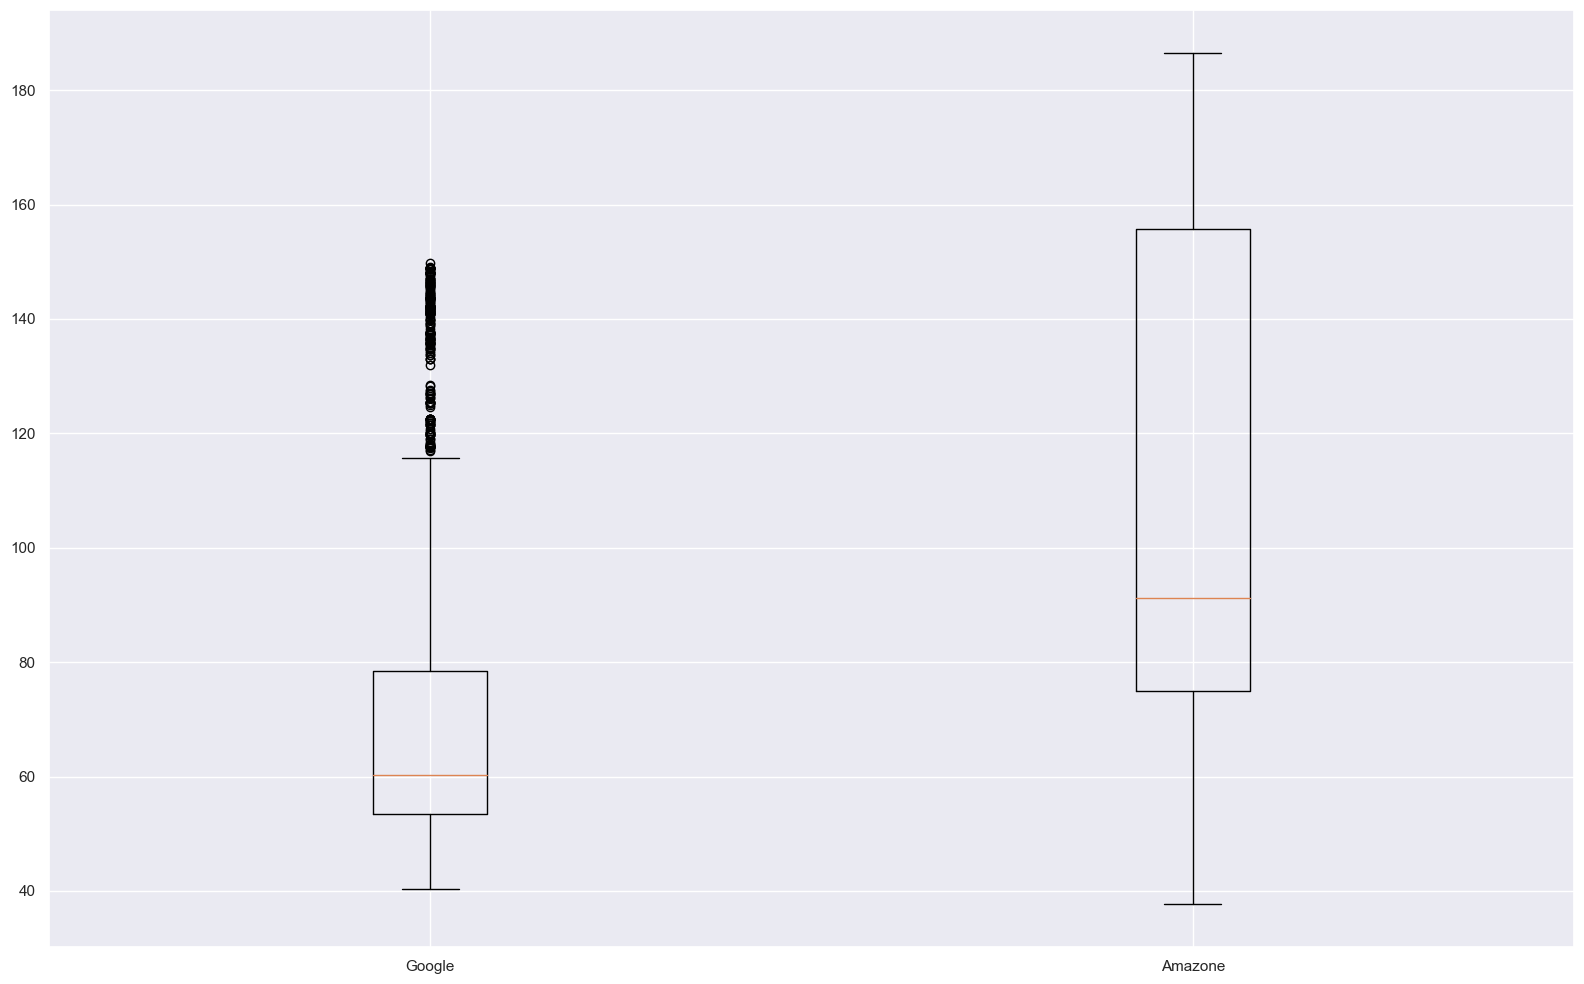

In [112]:
plt.figure(figsize=(16,10))
plt.boxplot([data1, data2])
plt.xticks([1, 2], ['Google','Amazone'])
plt.show()

Средняя цена закрытия для Google около 72, y Amazone - 104. У данных с Google очень много выбросов, что видно на графике boxplot. У Amazone выбросов нет.

# Рассмотрим цены за каждый месяц

In [113]:
monthly_resampled_data1 = data1.resample('M').mean()
monthly_resampled_data2 = data2.resample('M').mean()

In [114]:
hvplot.plot(monthly_resampled_data1, width=800, height=400, kind='line', label="{}".format(name1))*hvplot.plot(monthly_resampled_data2, width=800, height=400, kind='line', label="{}".format(name2))

:Overlay
   .Curve.Google  :Curve   [Date]   (Close)
   .Curve.Amazone :Curve   [Date]   (Close)

Видно, что у обоих фирм есть ярко выраженные пики: сентябрь 2018 года, февраль 2020, август 2020 для Amazone.
У обоих фирм есть характерный спад в марте 2020 года, что может быть связано с эпидемией covid-19.


# Рассмотрим цены за год

In [115]:
yearly_resampled_data1 = data1.resample('Y').mean()
yearly_resampled_data2 = data2.resample('Y').mean()

In [116]:
hvplot.plot(yearly_resampled_data1, width=800, height=400, kind='line', label="{}".format(name1))*hvplot.plot(yearly_resampled_data2, width=800, height=400, kind='line', label="{}".format(name2))

:Overlay
   .Curve.Google  :Curve   [Date]   (Close)
   .Curve.Amazone :Curve   [Date]   (Close)

Видно, что у обоих фирм наблюдается четкий тренд.

# Rolling statistics

In [117]:
window=30

In [118]:
data1_rm = data1.rolling(window=window).mean()
data2_rm= data2.rolling(window=window).mean()

In [119]:
hvplot.plot(data2_rm, width=800, height=400, kind='line', label="{} rolling mean".format(name2))*hvplot.plot(data1_rm, width=800, height=400, kind='line', label="{} rolling mean".format(name1))

:Overlay
   .Curve.Amazone_rolling_mean :Curve   [Date]   (Close)
   .Curve.Google_rolling_mean  :Curve   [Date]   (Close)

# Исследование на нормальность распределения по Google

In [120]:
def check_normality(data, name):
    data=pd.DataFrame(data, columns=['Close'])
    data['boxcox'], _ =boxcox(data["Close"])
    data['log']=np.log(data['Close'])
    data['sqrt']=np.sqrt(data['Close'])

    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    sns.set(style="darkgrid")


    fig, axs = plt.subplots(2, 2, figsize=(12, 5))

    fig.suptitle(name)

    sns.histplot(data=data, x="Close", kde=True, color="skyblue", ax=axs[0,0])
    sns.histplot(data=data, x="boxcox", kde=True, color="gold", ax=axs[0,1])
    sns.histplot(data=data, x="log", kde=True, color="olive", ax=axs[1,0])
    sns.histplot(data=data, x="sqrt", kde=True, color="gold", ax=axs[1,1])


    plt.show()

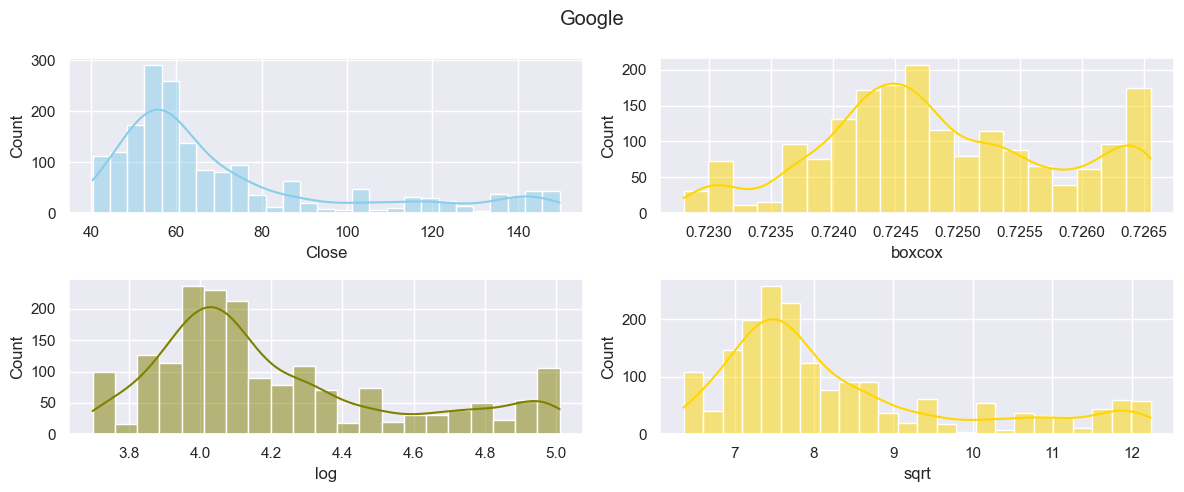

In [121]:
check_normality(data1, "Google")

Не смотря на все преобразования данные по Google не нормально распределены и имеют в основном положительно скошенное распределение.

# Исследование на нормальность распределения по Amazone


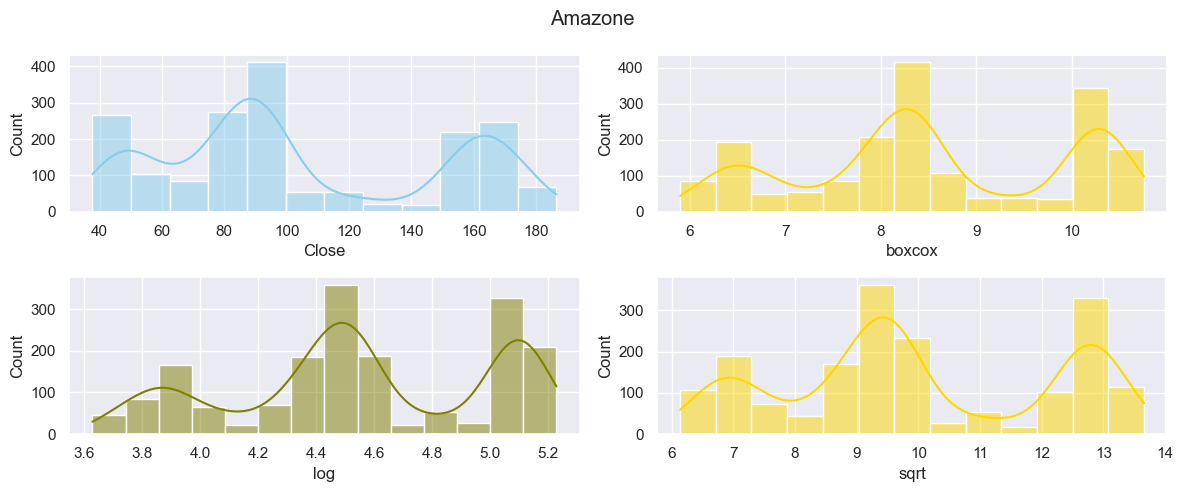

In [122]:
check_normality(data2, "Amazone")

Данные по Amazone не нормально распределены и имеют скорее мультмодальное распределение.


# Декомпозиция ряда на составляющие

# Google

In [123]:
data1_decomposed = seasonal_decompose(data1, model='additive')

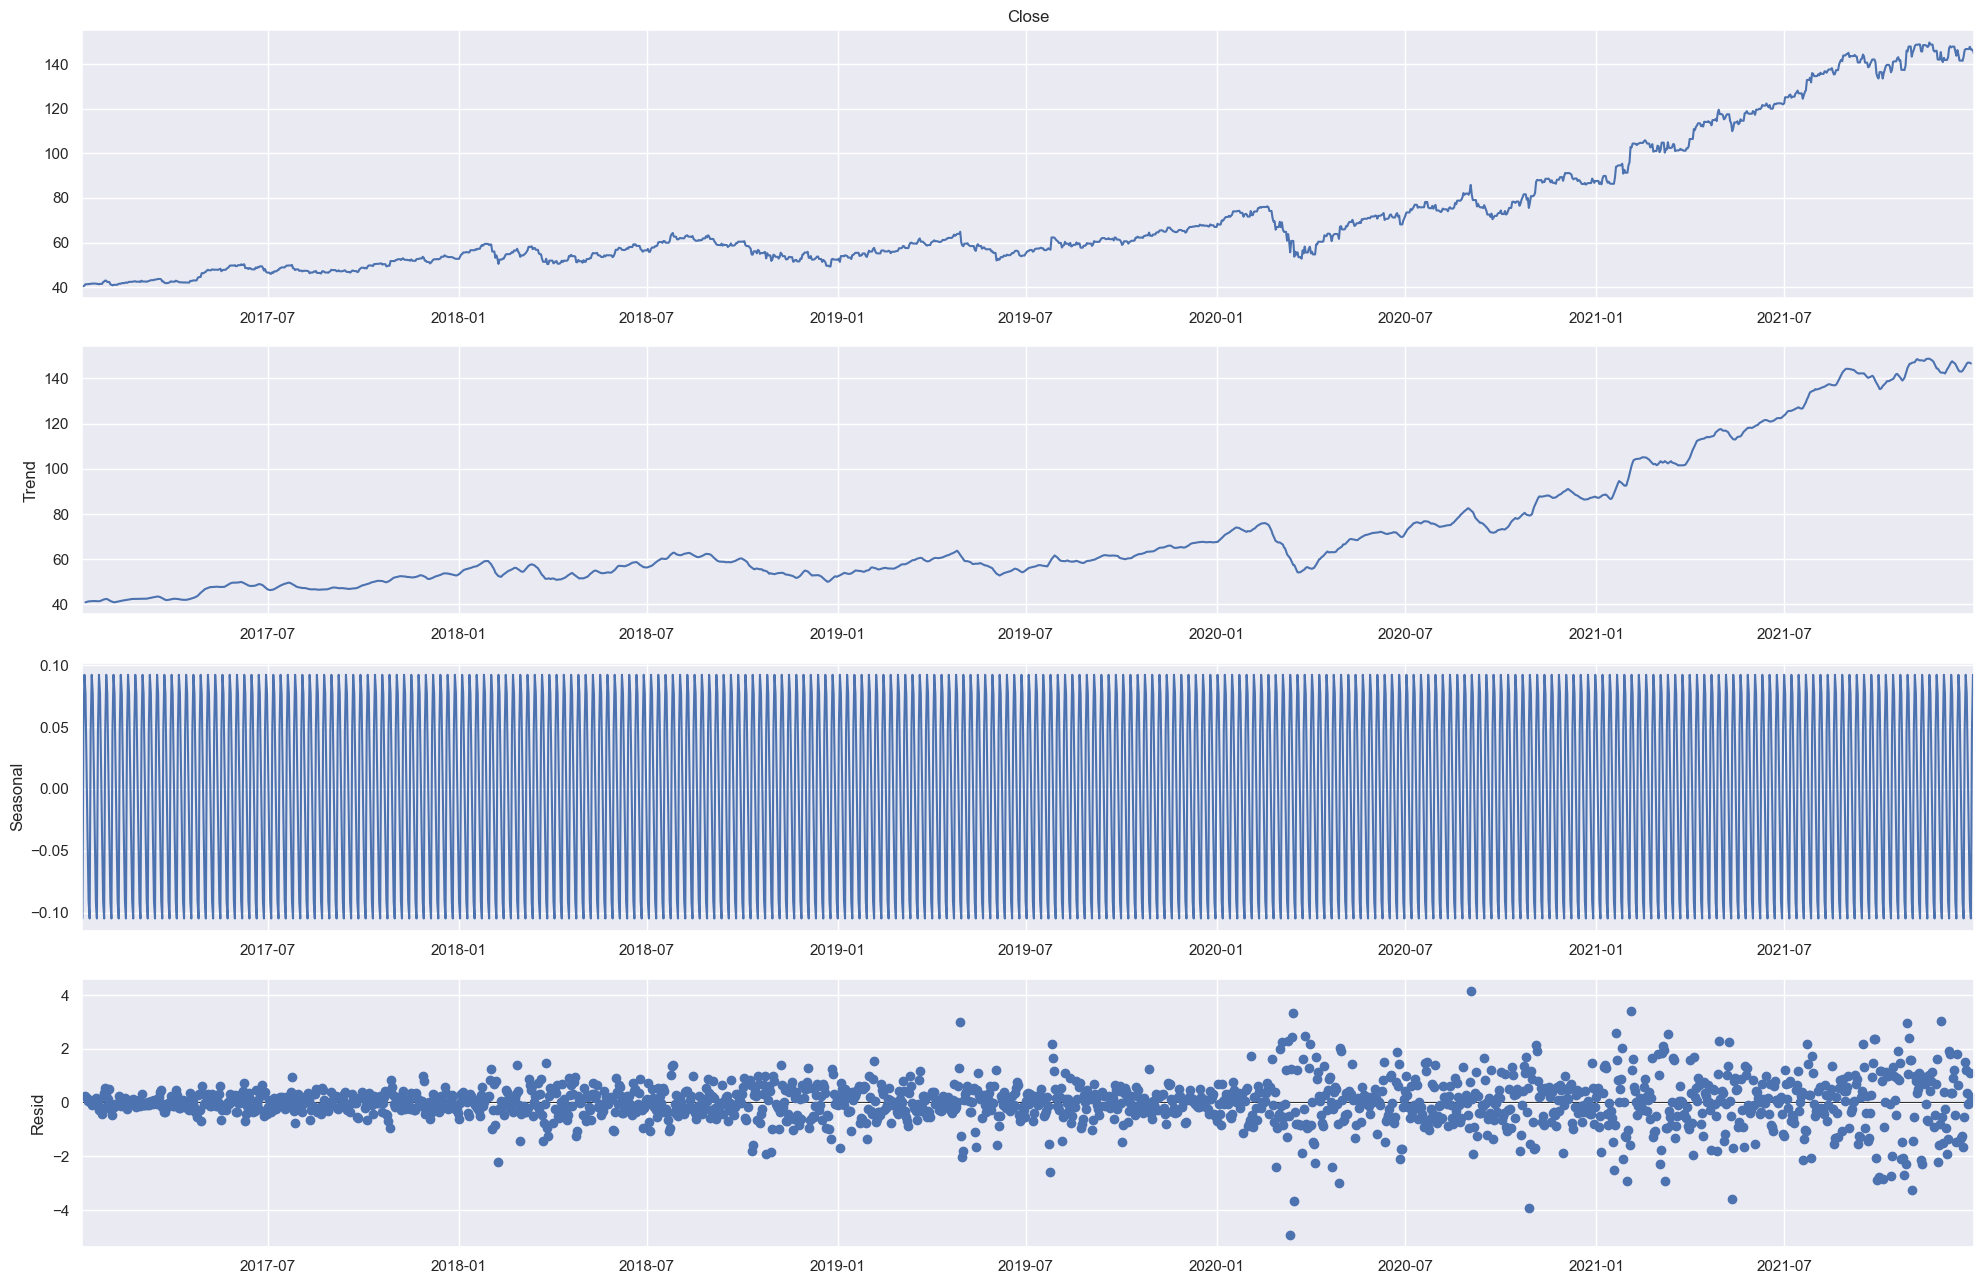

In [124]:
plt.rcParams["figure.figsize"] = (20,13)
data1_decomposed.plot()
plt.show();

ecть сезонность, остатки гетероскедостичны и не являются белым шумом

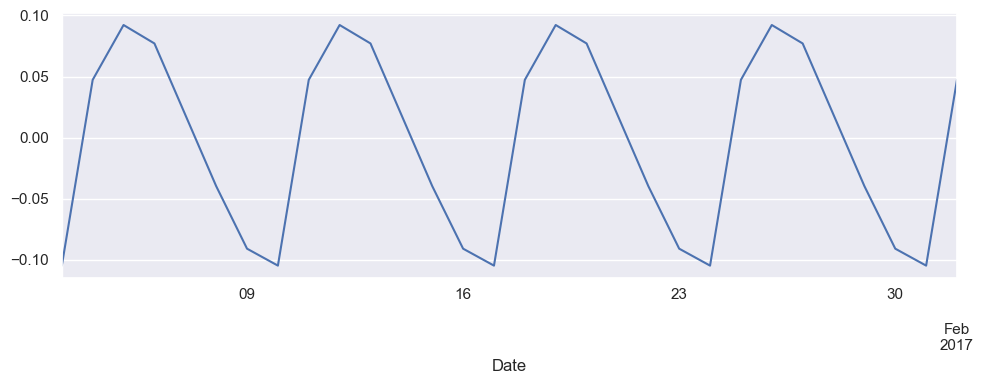

In [125]:
data1_decomposed.seasonal['2017-01-03':'2017-02-01'].plot(figsize=(10,4));

есть недельная сезонность

<AxesSubplot: title={'center': 'Google Trend Component'}, xlabel='Date'>

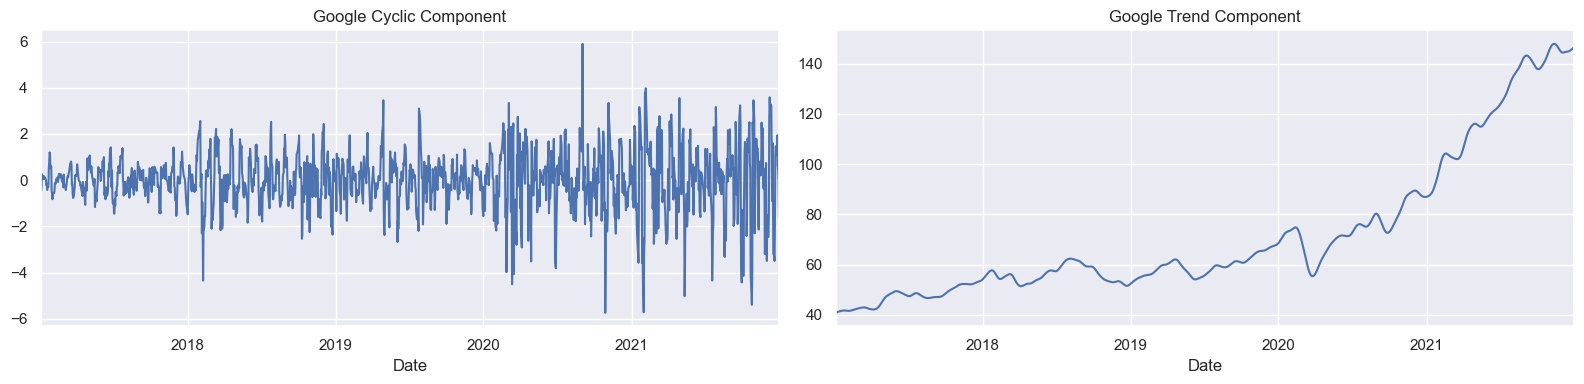

In [126]:
data1_cyclic, data1_trend = hpfilter(data1)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
data1_cyclic.plot(ax=ax[0], title='Google Cyclic Component')
data1_trend.plot(ax=ax[1], title='Google Trend Component')

на данном графике видно наличие цикла, с явными пиками

# Amazone

In [127]:
data2_decomposed = seasonal_decompose(data2, model='additive')

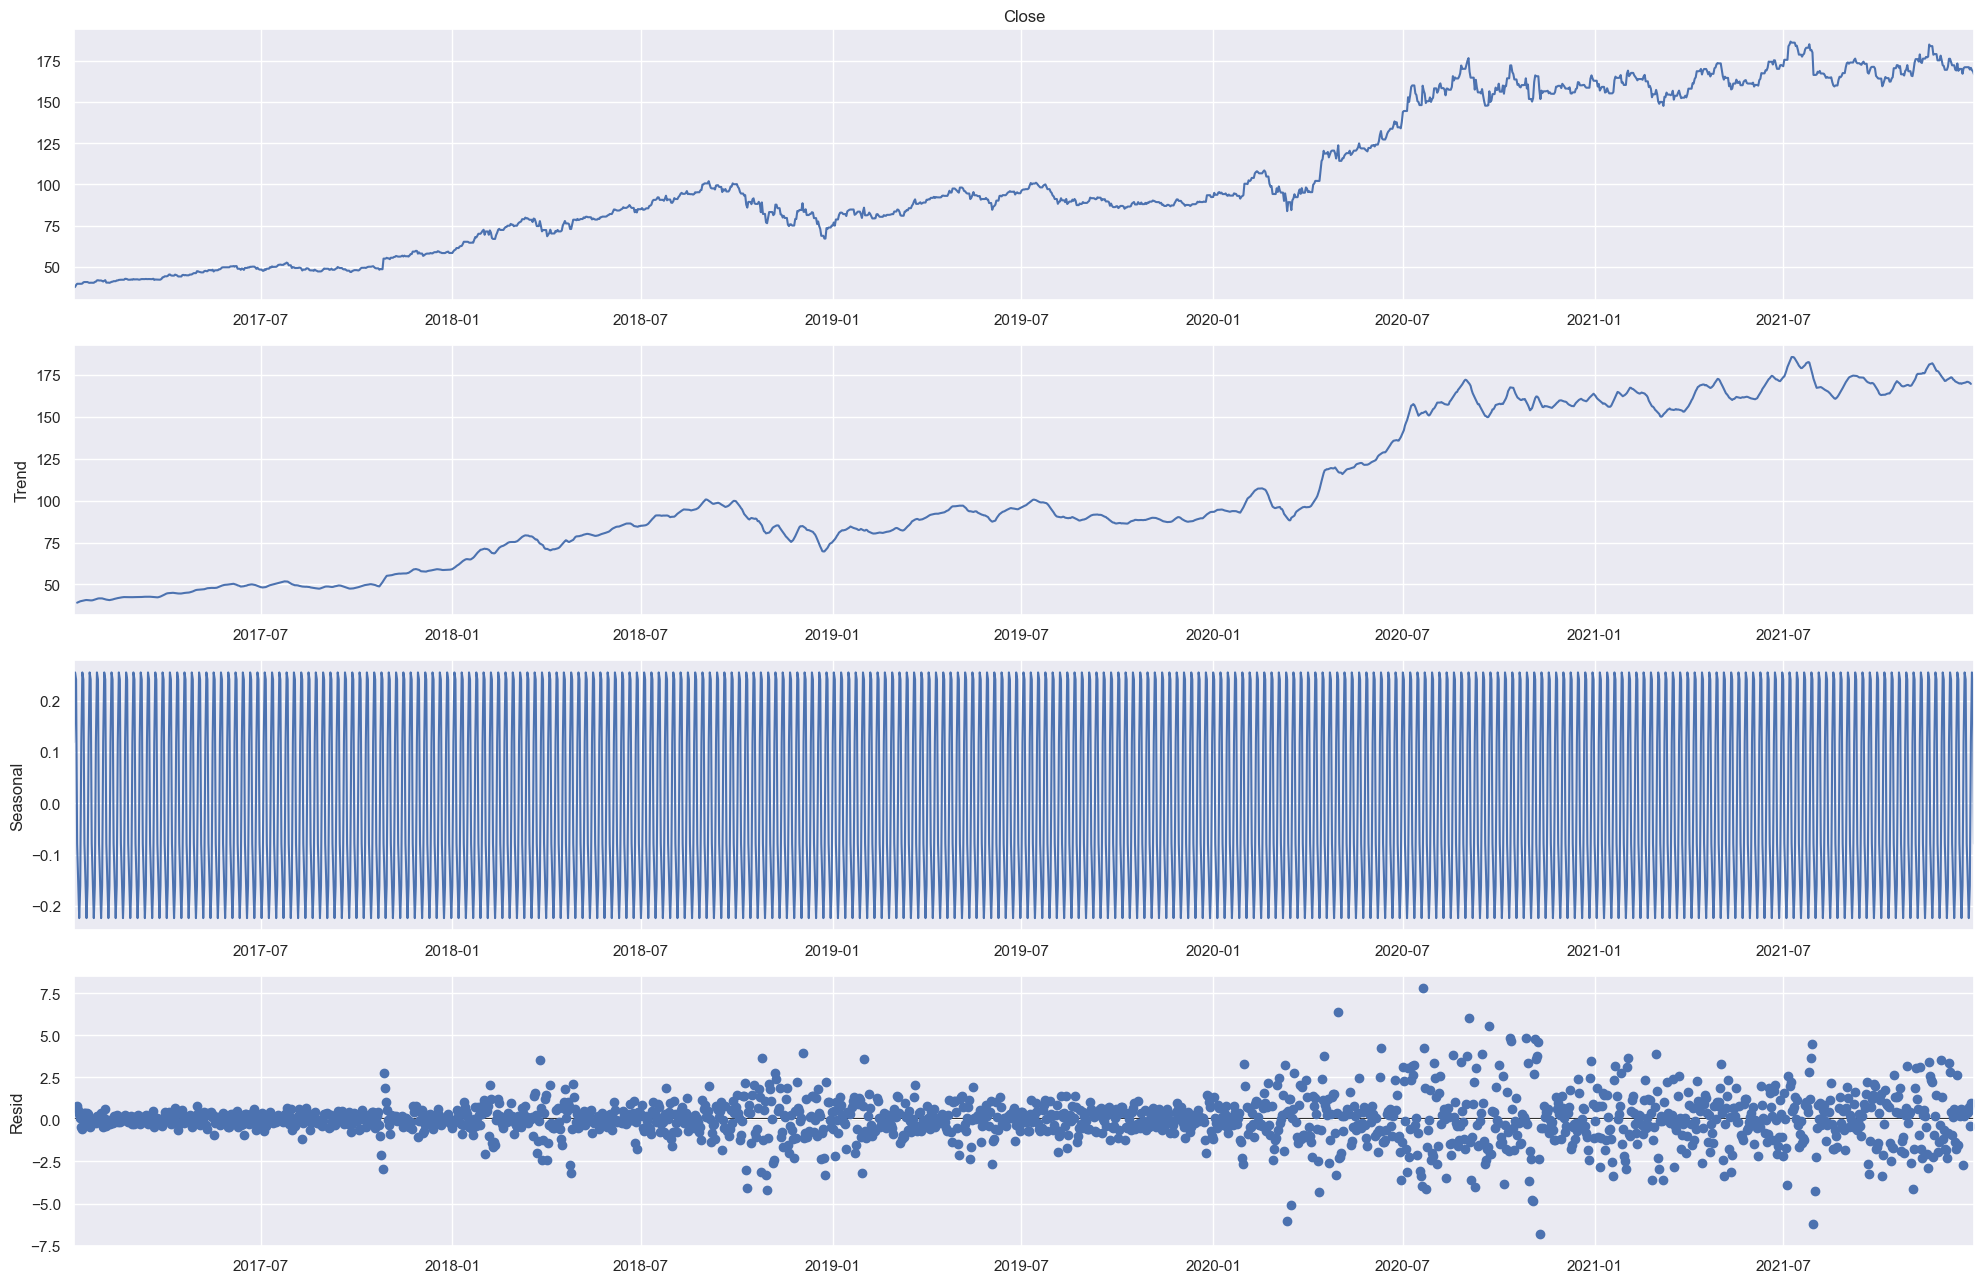

In [128]:
plt.rcParams["figure.figsize"] = (20,13)
data2_decomposed.plot()
plt.show();

аналогично, ecть сезонность, остатки гетероскедостичны и не являются белым шумом

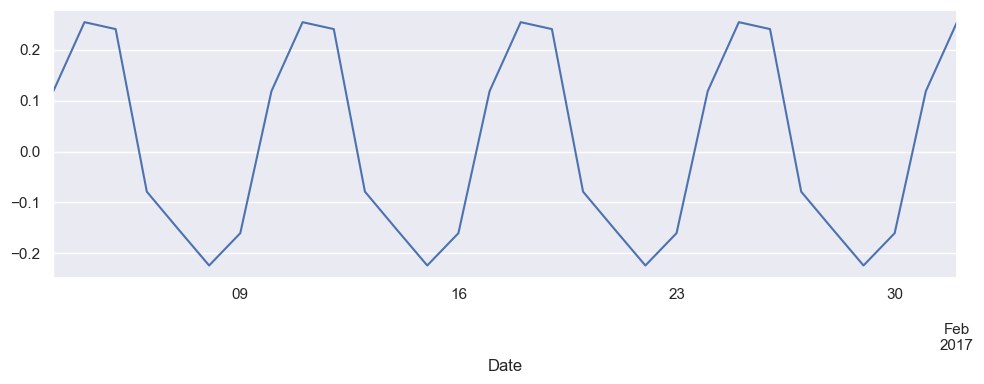

In [129]:
data2_decomposed.seasonal['2017-01-03':'2017-02-01'].plot(figsize=(10,4));

так же есть около недельная сезонность.

# Исследование на стационарность

# Google

Results of Dickey-Fuller Test:
Test Statistic                    1.335679
p-value                           0.996801
#Lags Used                       20.000000
Number of Observations Used    1803.000000
Critical Value (1%)              -3.433982
Critical Value (5%)              -2.863144
Critical Value (10%)             -2.567624
dtype: float64


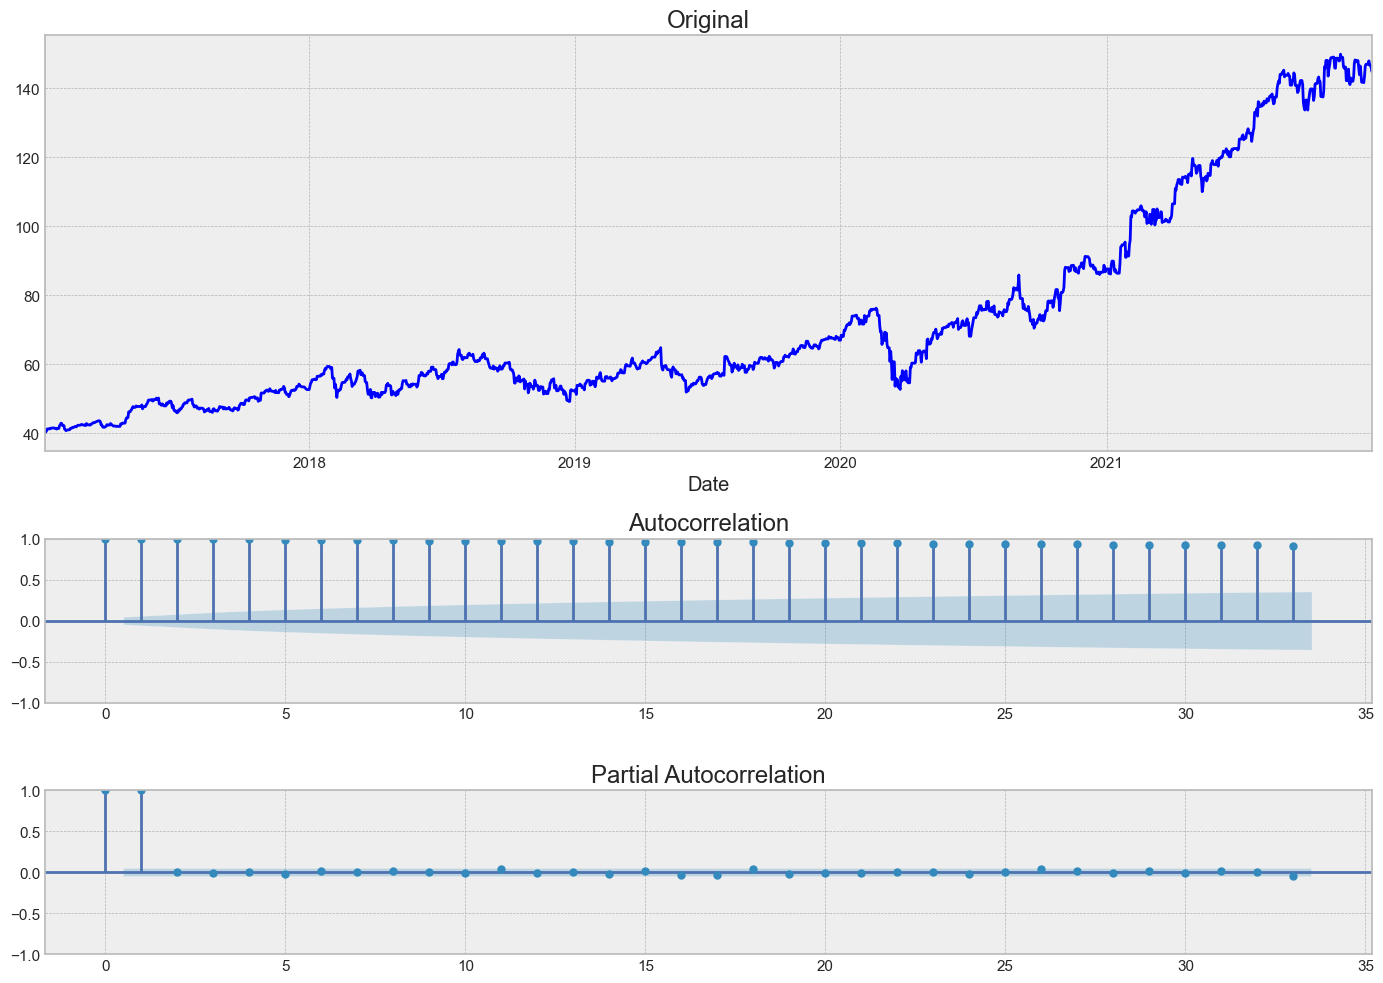

In [130]:
tsplot(data1)

Так как p-value>0.05, то нет оснований отвергать гипотезу о наличии единичного корня (ряд не стационарен) -> ряд не стационарен.

На графике автокорреляции присутствует сильная зависимость между лагами, попробуем применить преобразование Бокса-Кокса

In [131]:
data1_boxcox, _ =boxcox(data1)

Results of Dickey-Fuller Test:
Test Statistic                   -1.179065
p-value                           0.682536
#Lags Used                       12.000000
Number of Observations Used    1811.000000
Critical Value (1%)              -3.433966
Critical Value (5%)              -2.863137
Critical Value (10%)             -2.567620
dtype: float64


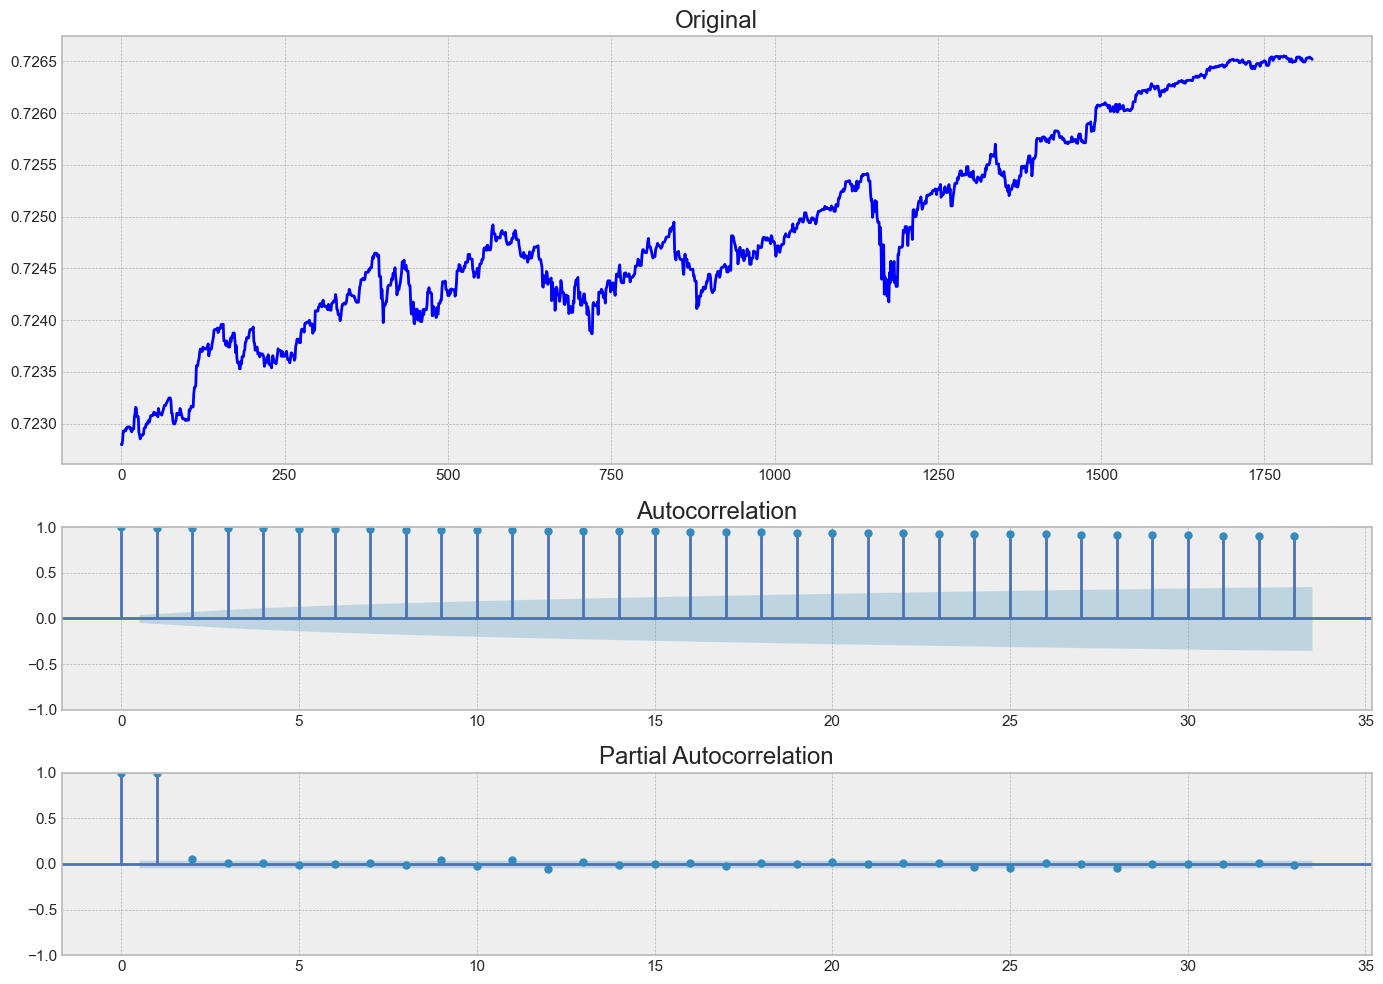

In [132]:
tsplot(data1_boxcox)

ряд все еще не стационарный, применим дифференцирование

In [133]:
data1_diff=np.diff(data1,1)

Results of Dickey-Fuller Test:
Test Statistic                -9.364702e+00
p-value                        7.655677e-16
#Lags Used                     1.900000e+01
Number of Observations Used    1.803000e+03
Critical Value (1%)           -3.433982e+00
Critical Value (5%)           -2.863144e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


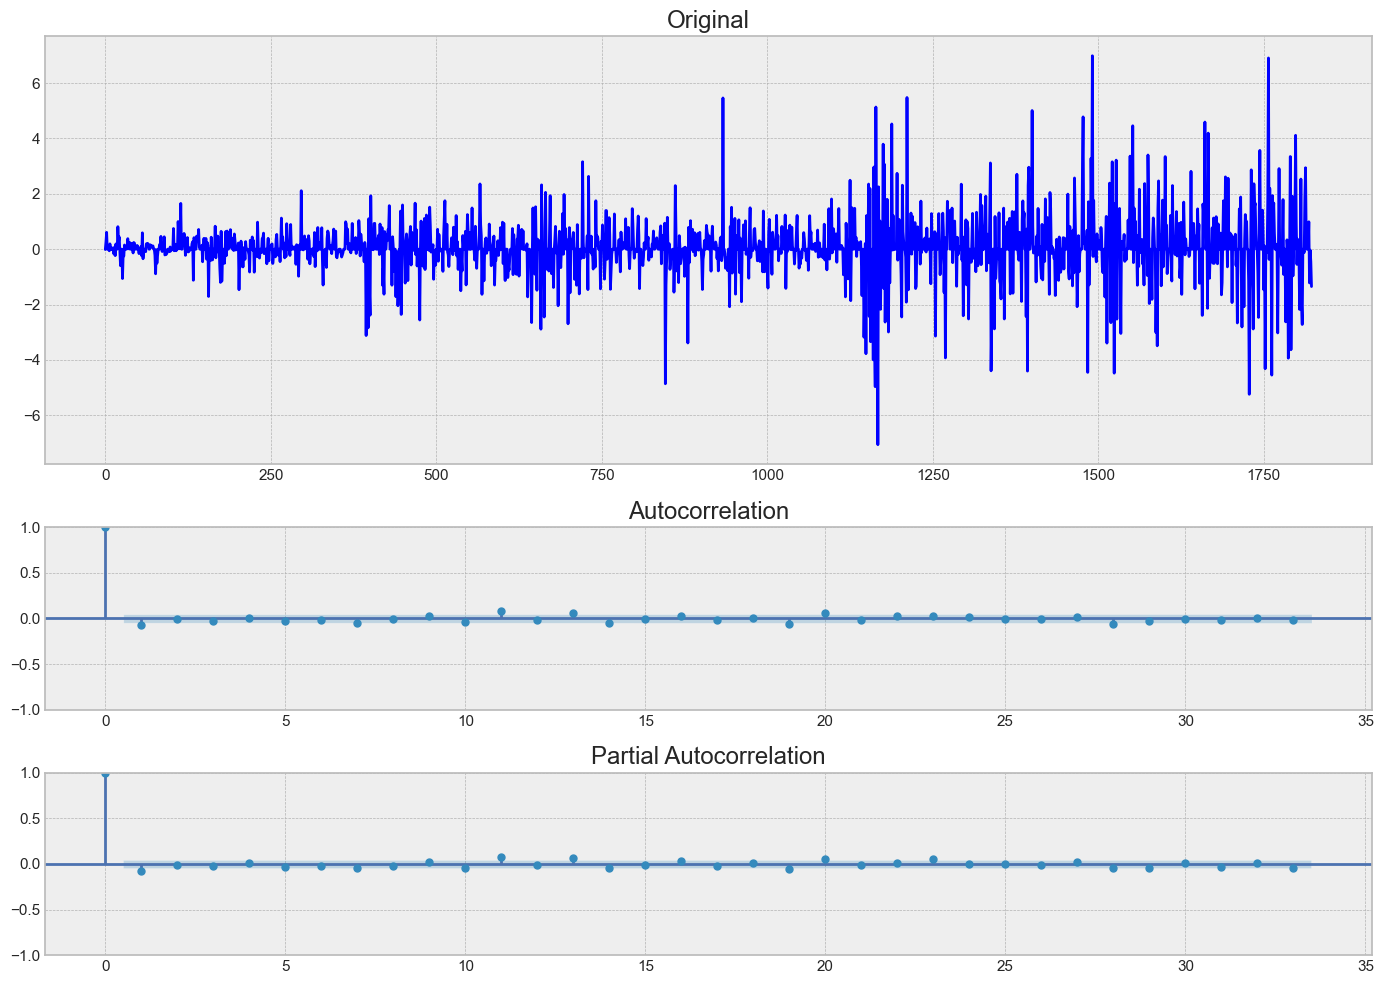

In [134]:
tsplot(data1_diff)

p-value << 0.05 -> ряд стационарный.

# Amazone

Results of Dickey-Fuller Test:
Test Statistic                   -0.762881
p-value                           0.829783
#Lags Used                       20.000000
Number of Observations Used    1803.000000
Critical Value (1%)              -3.433982
Critical Value (5%)              -2.863144
Critical Value (10%)             -2.567624
dtype: float64


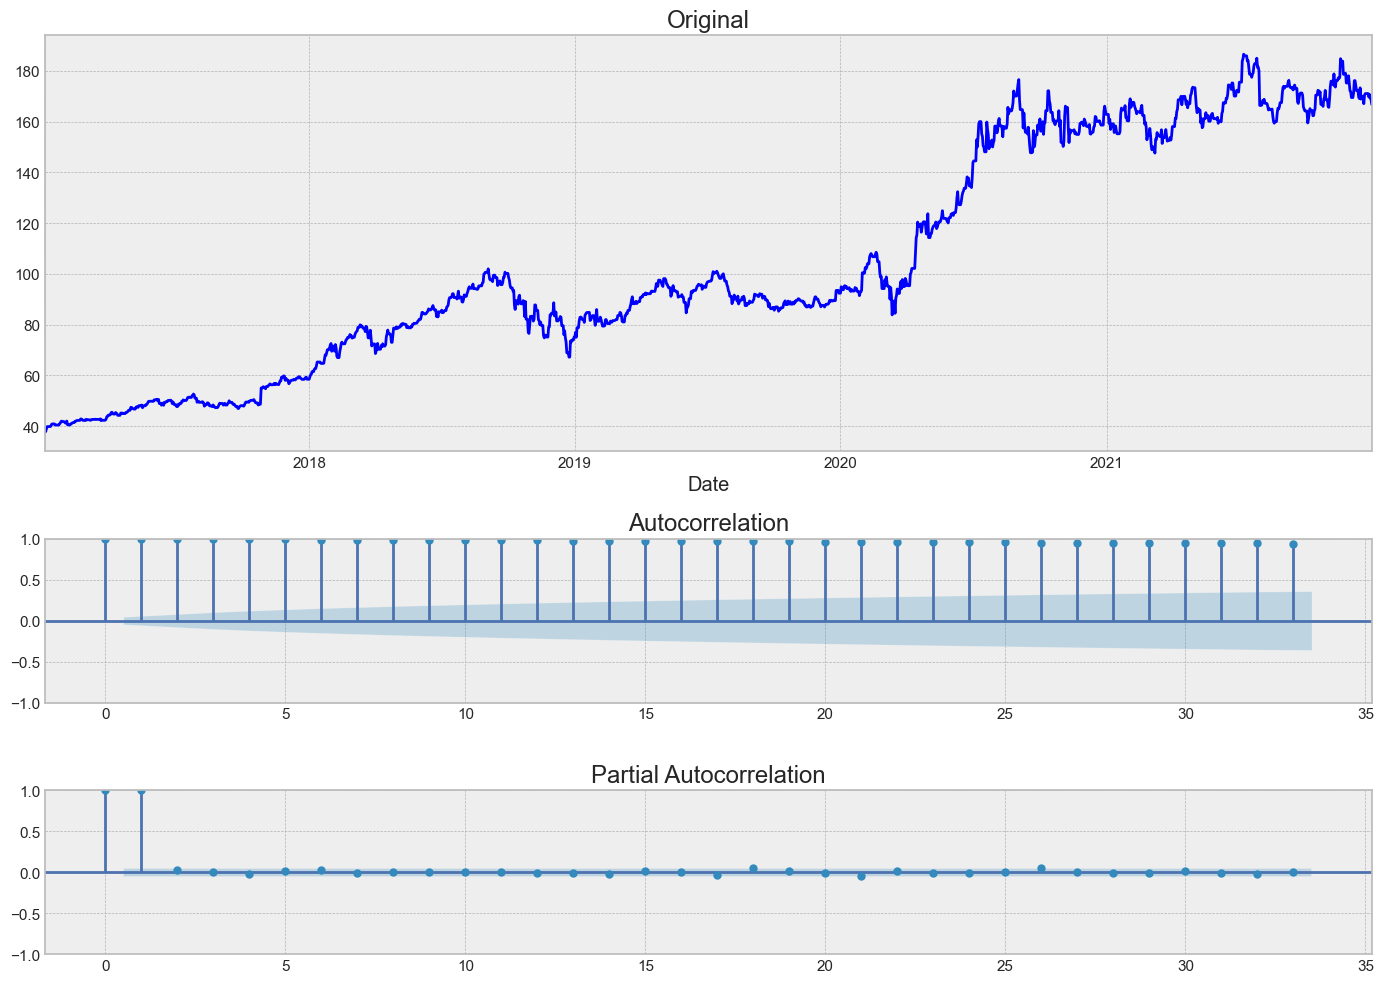

In [135]:
tsplot(data2)

Так как p-value=>0.05, то нет оснований отвергать гипотезу о наличии единичного корня (ряд не стационарен) -> ряд не стационарен.
Применим преобразование Бокса-Кокса

Results of Dickey-Fuller Test:
Test Statistic                   -1.277889
p-value                           0.639226
#Lags Used                        5.000000
Number of Observations Used    1818.000000
Critical Value (1%)              -3.433952
Critical Value (5%)              -2.863131
Critical Value (10%)             -2.567617
dtype: float64


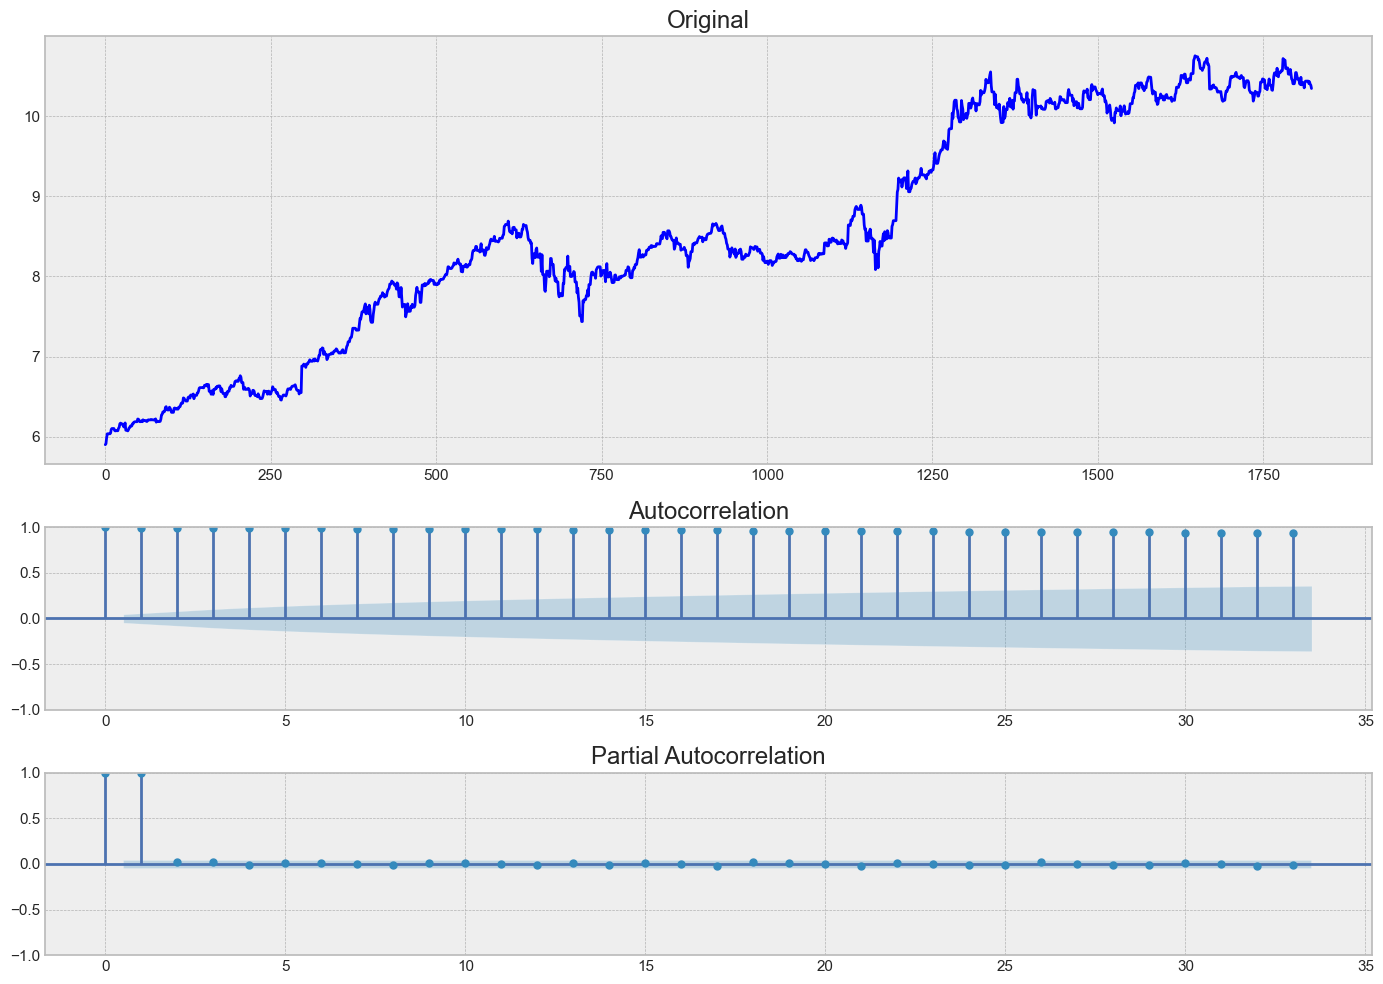

In [136]:
data2_boxcox, _ = boxcox(data2)
tsplot(data2_boxcox)

ряд все еще не стационарный. Применим дифференцирование.

Results of Dickey-Fuller Test:
Test Statistic                -9.768139e+00
p-value                        7.256450e-17
#Lags Used                     1.900000e+01
Number of Observations Used    1.803000e+03
Critical Value (1%)           -3.433982e+00
Critical Value (5%)           -2.863144e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


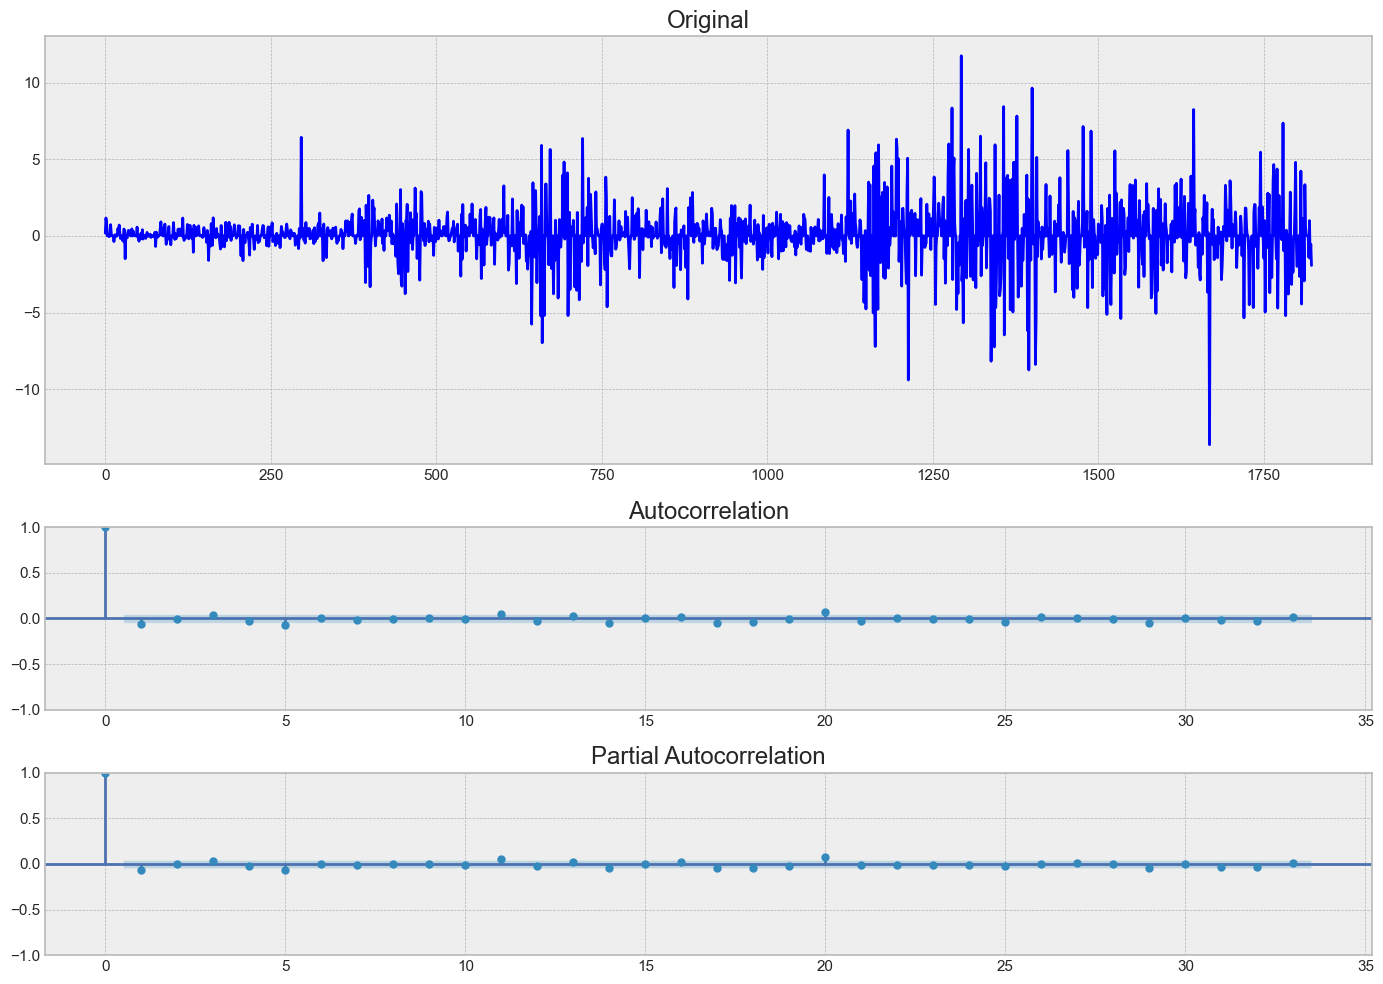

In [137]:
data2_diff=np.diff(data2,1)
tsplot(data2_diff)

p-value < 0.05 -> получили стационарный ряд.

# Выводы
Были исследованы дневные данные о ценах закрытия двух компаний Google и Amazone за период с 2017 по 2022 годы. Получены следующие выводы:

1. Оба временных ряда не стационарны, обладают четко прослеживающимся трендом, есть около недельная сезонность.
2. В основном все средние показатели у ряда цен компании Amazone выше, чем у Google, что видно по графикам.
3. Оба ряда не имеют нормального распределения, и после применения преобразований типа логарифма и квадратного корня они не становятся нормально распределенными.
4. У данных с Google очень много выбросов, что видно на графике boxplot. У Amazone выбросов нет.
5. У обоих рядов есть несколько периодов роста c явными падениями в декабре 2018 и в марте 2020 (может быть связано с covid-19).

# Задание 2. Прогнозирование цен компании Google

In [138]:
data=pd.DataFrame(data1)

In [139]:
data.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

Results of Dickey-Fuller Test:
Test Statistic                    1.335679
p-value                           0.996801
#Lags Used                       20.000000
Number of Observations Used    1803.000000
Critical Value (1%)              -3.433982
Critical Value (5%)              -2.863144
Critical Value (10%)             -2.567624
dtype: float64


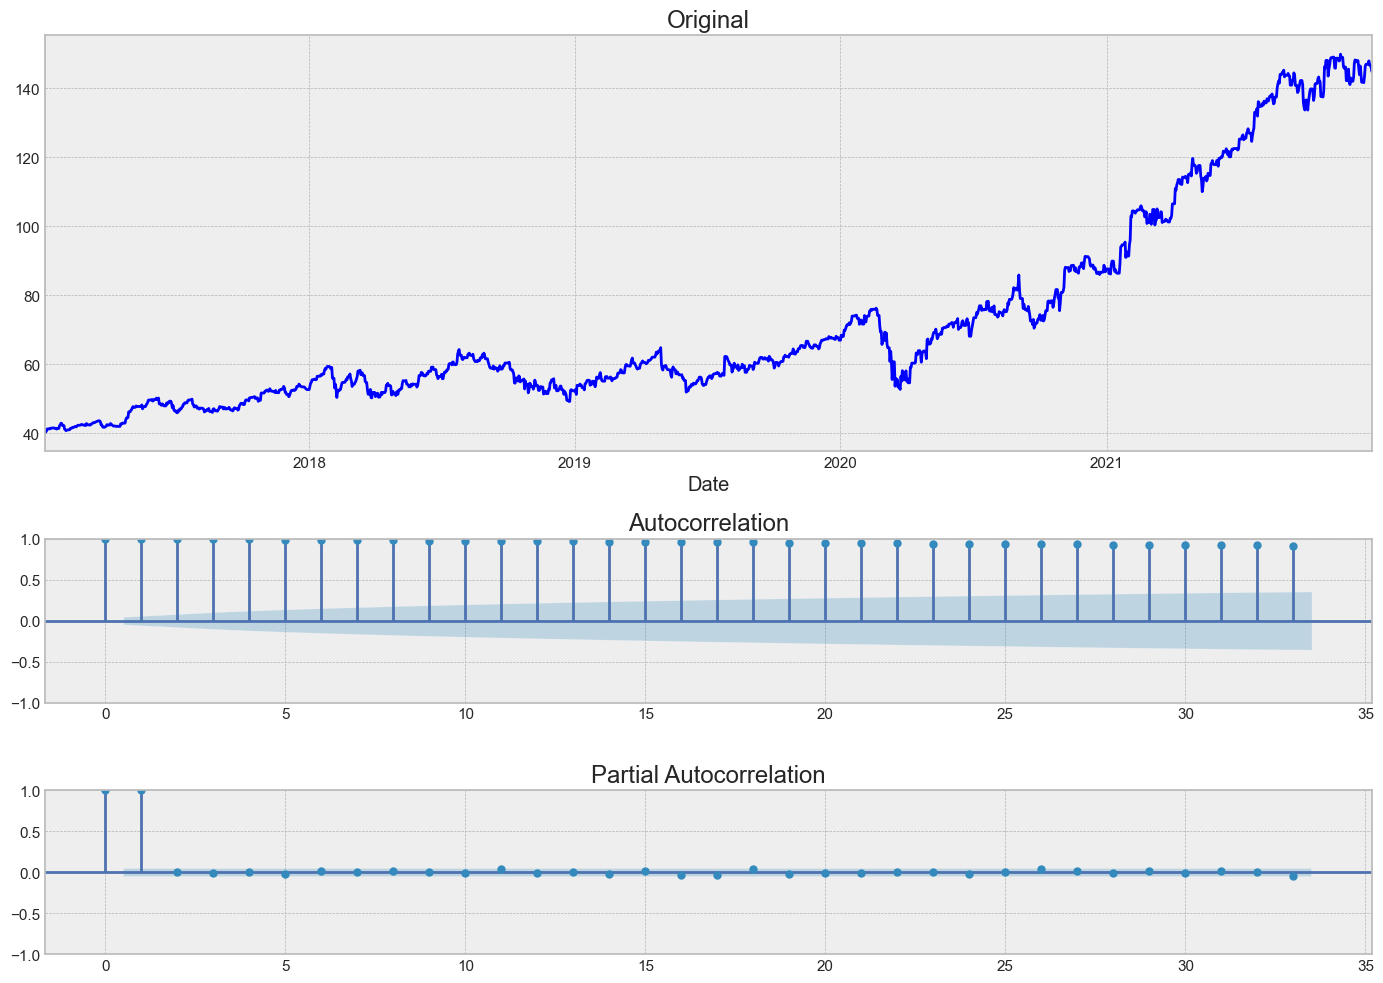

In [140]:
tsplot(data['Close'])

ряд не стационарный, применим дифференцирование:

Results of Dickey-Fuller Test:
Test Statistic                -9.364702e+00
p-value                        7.655677e-16
#Lags Used                     1.900000e+01
Number of Observations Used    1.803000e+03
Critical Value (1%)           -3.433982e+00
Critical Value (5%)           -2.863144e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


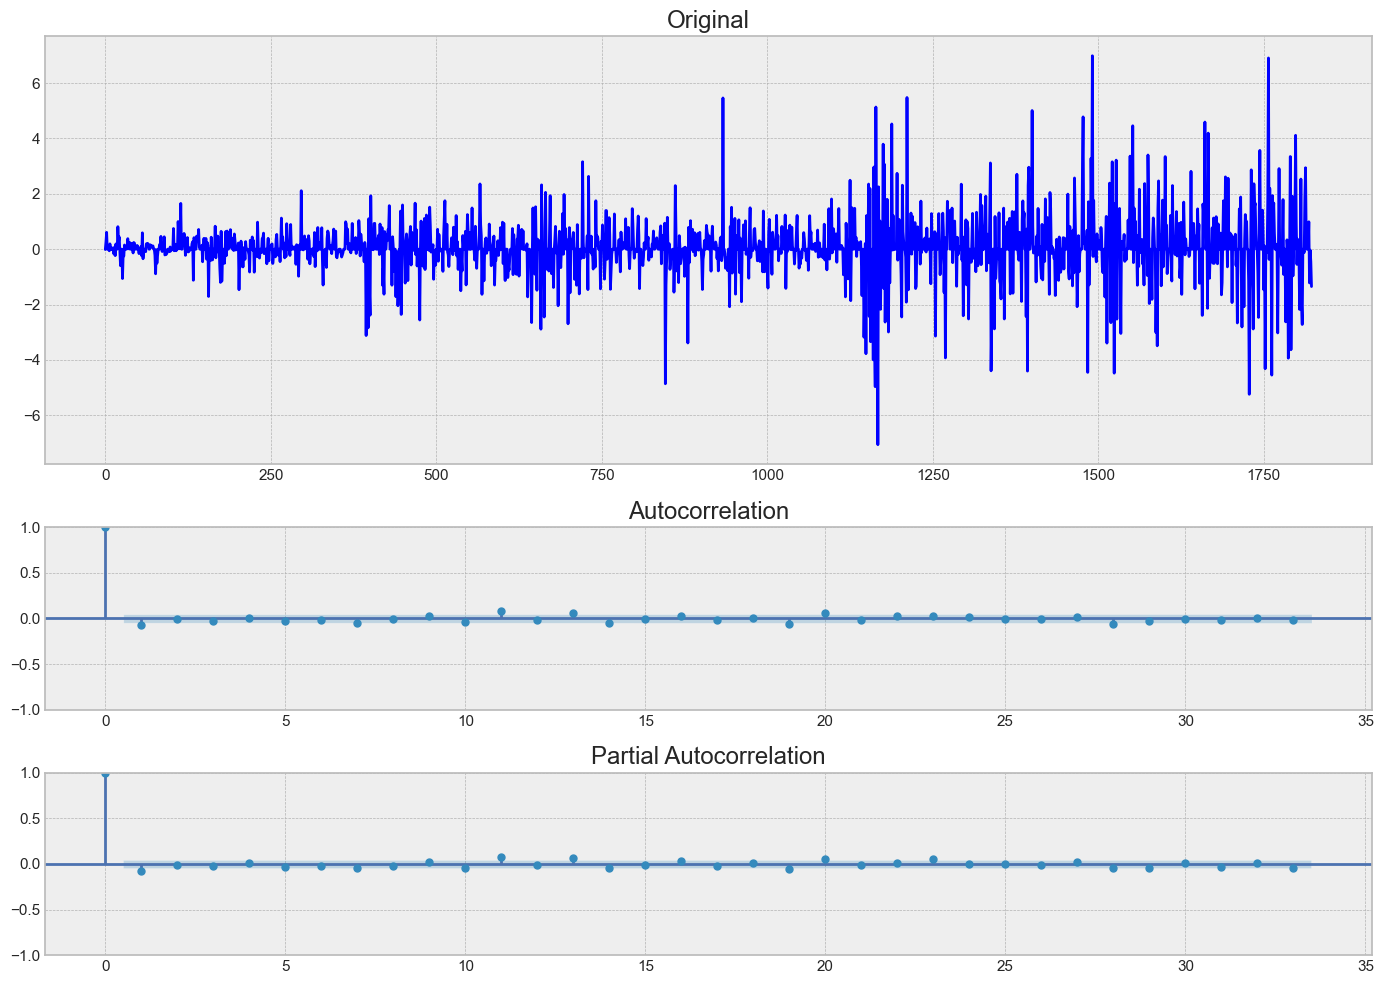

In [141]:
data1_diff = np.diff(data1, 1)
tsplot(data1_diff)

теперь ряд стационарный, пробуем модель ARIMA.

# ARIMA

In [142]:
#отложим 20% на тест ~ 365 дней
Ntest = 365
train = data.iloc[:-Ntest]
test = data.iloc[-Ntest:]

train_idx = data.index <= train.index[-1]
test_idx = data.index > train.index[-1]

In [143]:
from statsmodels.tsa.arima.model import ARIMA
d=1 #было дифференцирование
p=1 #так как на графике pacf после дифференцирования остался 1 значимый лаг
q=1 #так как на графике acf после дифференцирования остался 1 значимый лаг
#самая простая модель
arima = ARIMA(train, order=(1,1,1))

In [144]:
arima_result = arima.fit()

In [145]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1459
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1886.461
Date:                Sat, 22 Oct 2022   AIC                           3778.921
Time:                        14:17:55   BIC                           3794.776
Sample:                    01-03-2017   HQIC                          3784.836
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0304      0.147      0.207      0.836      -0.257       0.318
ma.L1         -0.1584      0.147     -1.077      0.281      -0.447       0.130
sigma2         0.7787      0.012     64.967      0.000       0.755       0.802
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6380.51
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.69   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [146]:
data.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

<AxesSubplot: xlabel='Date'>

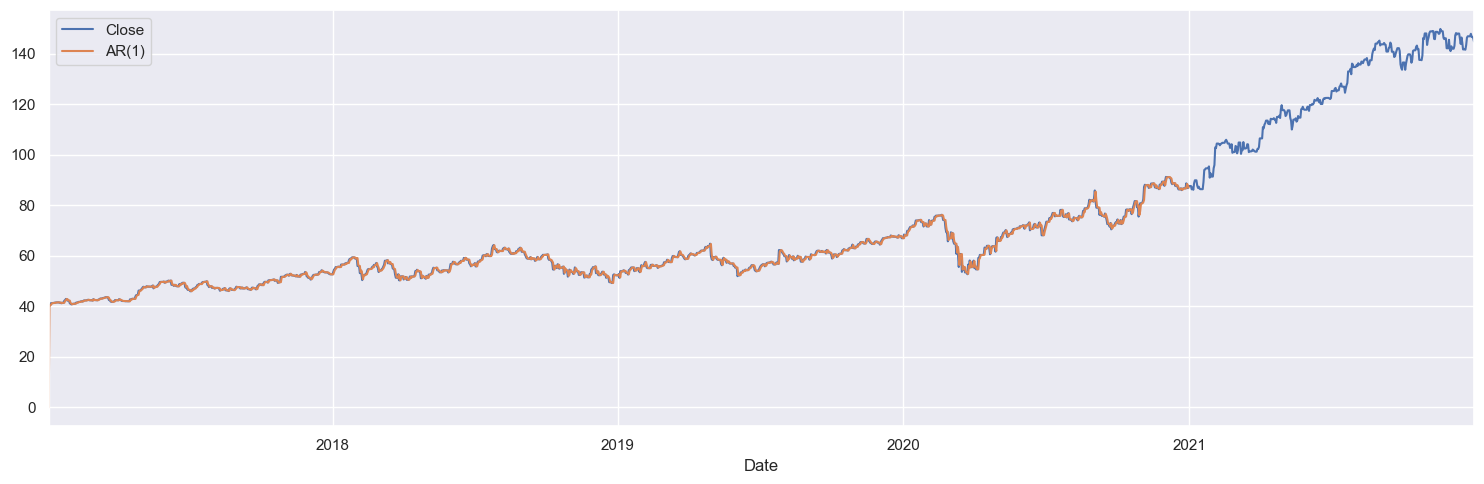

In [147]:
data[['Close', 'AR(1)']].plot(figsize=(15, 5))

<AxesSubplot: xlabel='Date'>

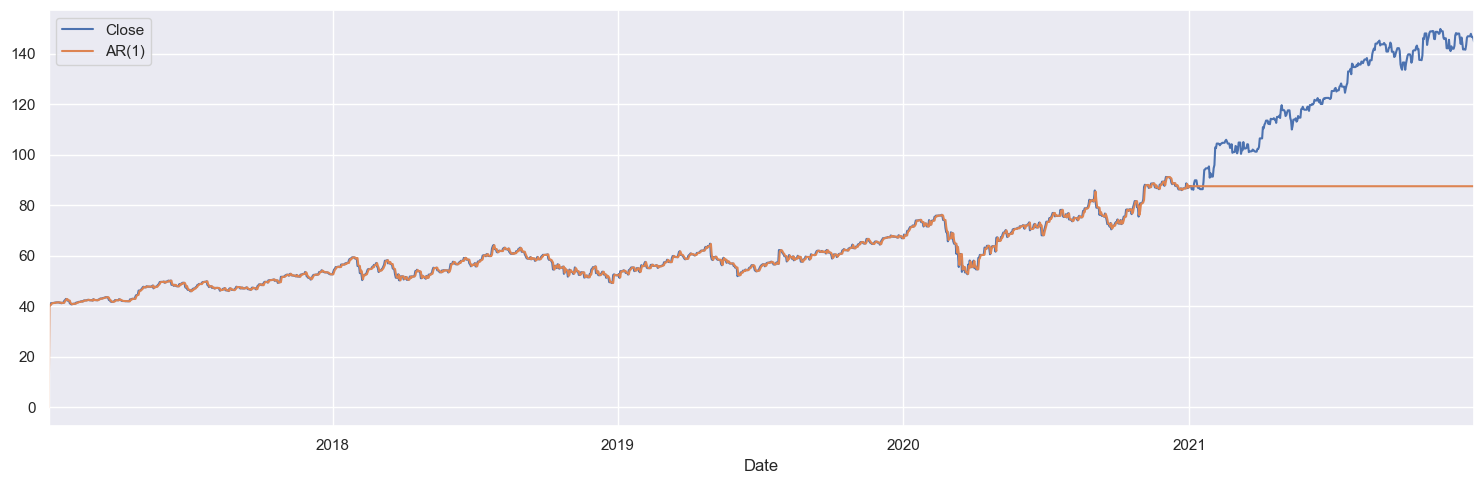

In [148]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
data.loc[test_idx, 'AR(1)'] = forecast
data[['Close', 'AR(1)']].plot(figsize=(15, 5))

предсказание не уловило закономерностей, пробуем авто подбор модели

In [149]:
import pmdarima as pm

In [150]:
model = pm.auto_arima(train['Close'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True,
                      m=7)
#cезонность недельная
# Посмотрим на лучшие параметры модели:
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3783.717, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3798.726, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3778.619, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3777.687, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3798.661, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3776.363, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3777.740, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3778.897, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=3778.311, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=3778.298, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3777.197, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=3780.210, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=3776.950, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7] intercept
Total fit time: 5.448 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1459
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1885.181
Date:                Sat, 22 Oct 2022   AIC                           3776.363
Time:                        14:18:01   BIC                           3792.217
Sample:                    01-03-2017   HQIC                          3782.278
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0323      0.020      1.579      0.114      -0.008       0.072
ma.L1         -0.1307      0.016     -8.154      0.000      -0.162      -0.099
sigma2         0.7773      0.012     65.118      0.000       0.754       0.801
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6381.83
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.69   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

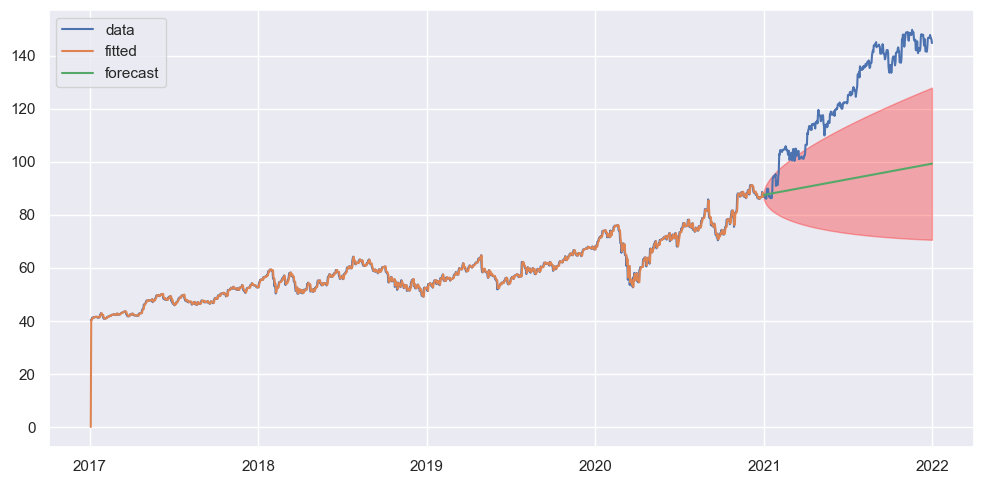

In [151]:
test_predictions, confidence_interval = model.predict(n_periods=Ntest, return_conf_int=True)
train_predictions = model.predict_in_sample(start=train.index[0], end=train.index[-1])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data.index, data['Close'], label='data')
ax.plot(train.index, train_predictions, label='fitted')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

плохой прогноз, пробуем другую модель.

# Prophet model

In [152]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [153]:
from prophet import Prophet

# отложим примерно год
predictions = 360


data = data1.reset_index()
data.columns = ['ds', 'y']
data.tail()

,ds,y
1819,2021-12-27,147.906494
1820,2021-12-28,146.686996
1821,2021-12-29,146.654999
1822,2021-12-30,146.200500
1823,2021-12-31,144.852005


In [154]:
train_df = data[:-predictions]

In [155]:
train_df

,ds,y
0,2017-01-03,40.400501
1,2017-01-04,40.388500
2,2017-01-05,40.651001
3,2017-01-06,41.260502
4,2017-01-07,41.260502
...,...,...
1459,2021-01-01,87.632004
1460,2021-01-02,87.632004
1461,2021-01-03,87.632004
1462,2021-01-04,86.306503


In [156]:
#сразу добавим праздники
from prophet.make_holidays import make_holidays_df

year_list = data['ds'].dt.year.unique().tolist()
# добавляем праздники на год вперед
year_list.append(year_list[-1] + 1)
holidays = make_holidays_df(year_list=year_list,
                            country='US')

In [157]:
model = Prophet(seasonality_mode='additive', weekly_seasonality=True, yearly_seasonality=False,
                holidays=holidays)



#добавляем квартальную сезонность (данные финансовые)
model.add_seasonality(name='quarterly',
                      period=365.25 / 4,
                      fourier_order=5)


model.fit(train_df)


future = model.make_future_dataframe(periods=predictions)

14:18:02 - cmdstanpy - INFO - Chain [1] start processing
14:18:02 - cmdstanpy - INFO - Chain [1] done processing


In [158]:
forecast = model.predict(future)

Mean absolute percentage error 14.21%


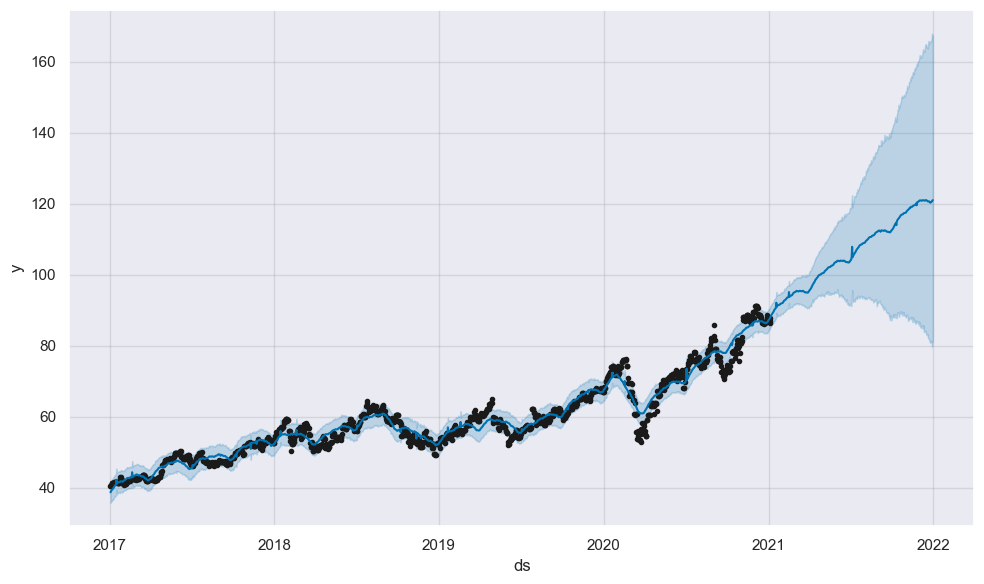

In [159]:
error = mean_absolute_percentage_error(data[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

ошибка на тесте порядка 14%

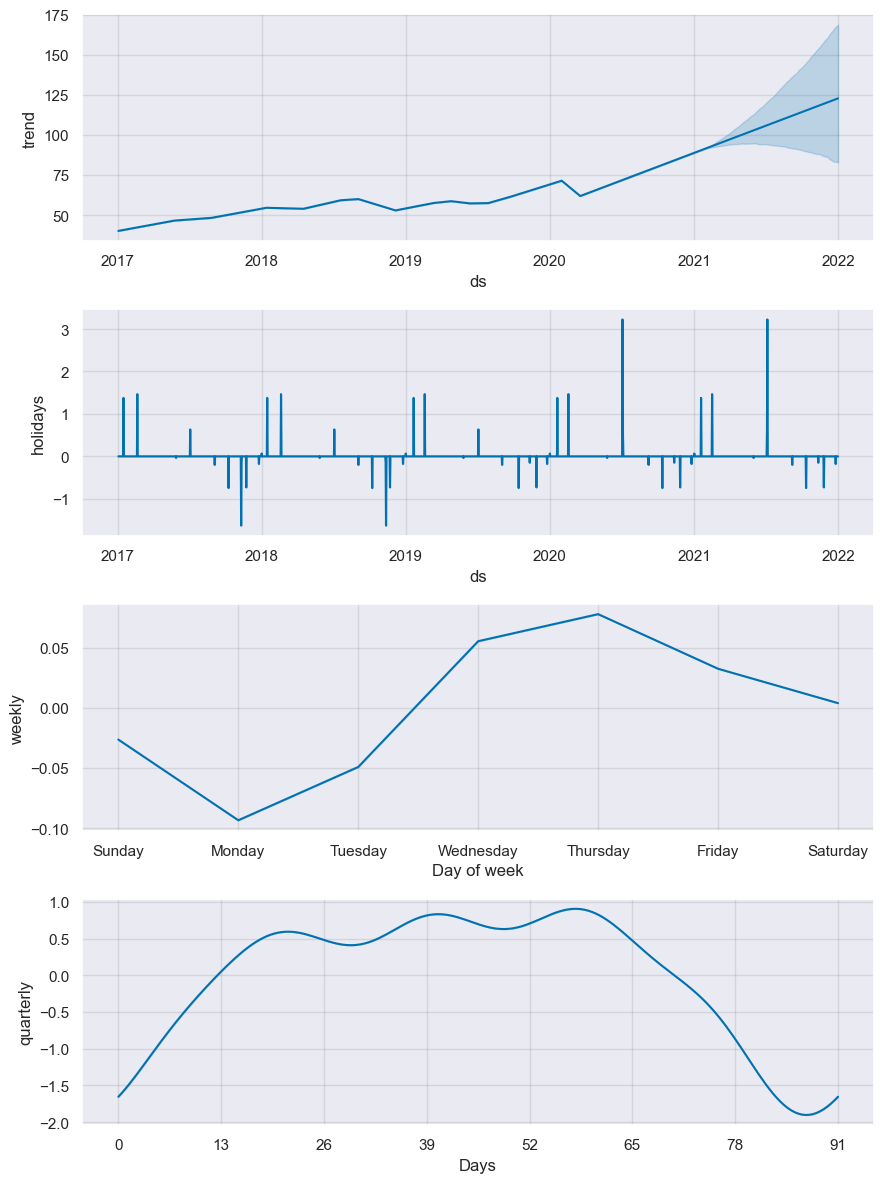

In [160]:
_ = model.plot_components(forecast)

пробуем мультипликативную модель

In [161]:
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, yearly_seasonality=False,
                holidays=holidays)


model.add_seasonality(name='quarterly',
                      period=365.25 / 4,
                      fourier_order=5)


model.fit(train_df)


future = model.make_future_dataframe(periods=predictions)

14:18:05 - cmdstanpy - INFO - Chain [1] start processing
14:18:05 - cmdstanpy - INFO - Chain [1] done processing


In [162]:
forecast = model.predict(future)

Mean absolute percentage error 14.21%


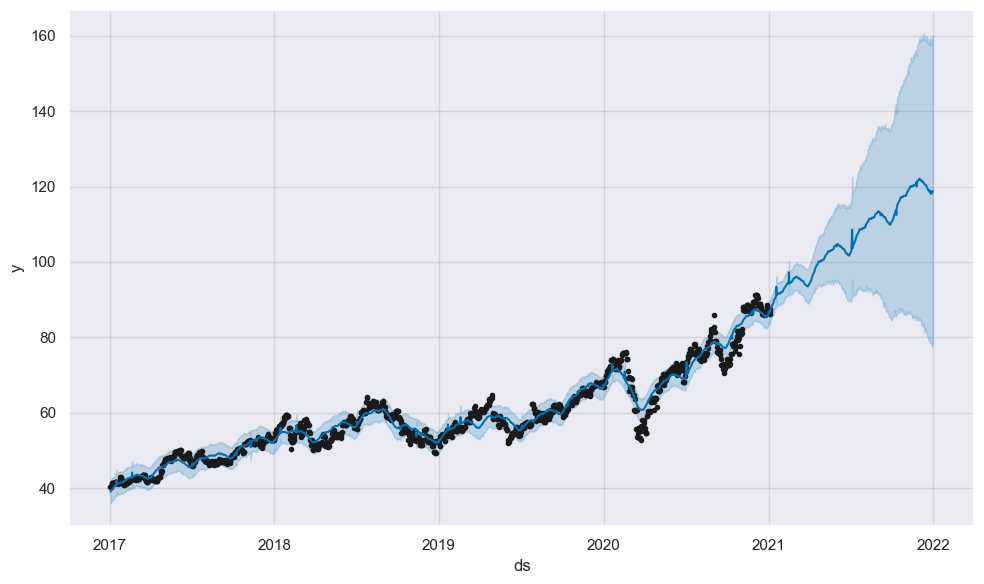

In [163]:
error = mean_absolute_percentage_error(data[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

ошибка не изменилась.

пробуем добавить регуляризацию на сезонность и на праздники

In [164]:
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, yearly_seasonality=False,
                holidays=holidays,
                seasonality_prior_scale=0.5,
                holidays_prior_scale=50)



model.add_seasonality(name='quarterly',
                      period=365.25 / 4,
                      fourier_order=5)


model.fit(train_df)


future = model.make_future_dataframe(periods=predictions)

14:18:06 - cmdstanpy - INFO - Chain [1] start processing
14:18:07 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 13.97%


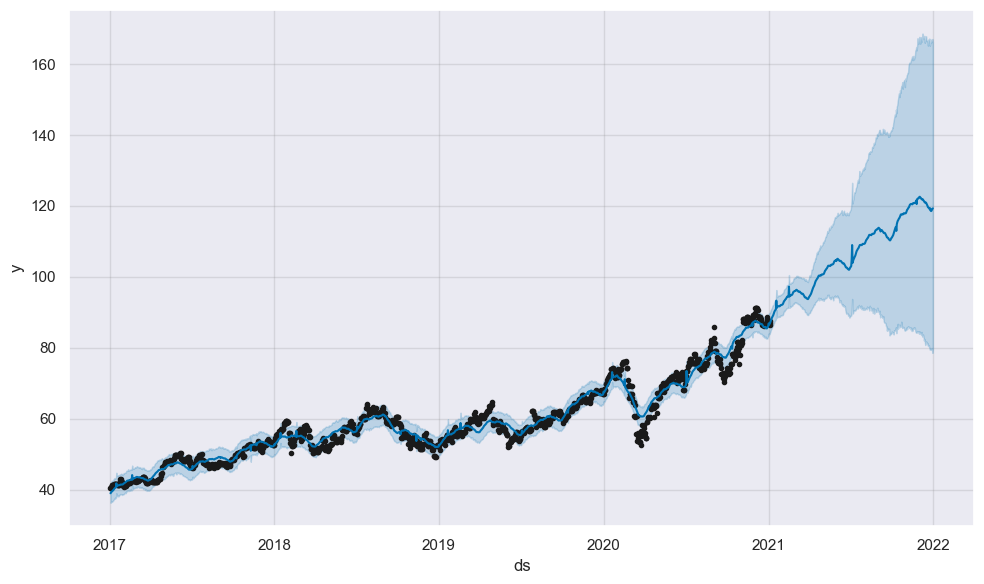

In [165]:
forecast = model.predict(future)
error = mean_absolute_percentage_error(data[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

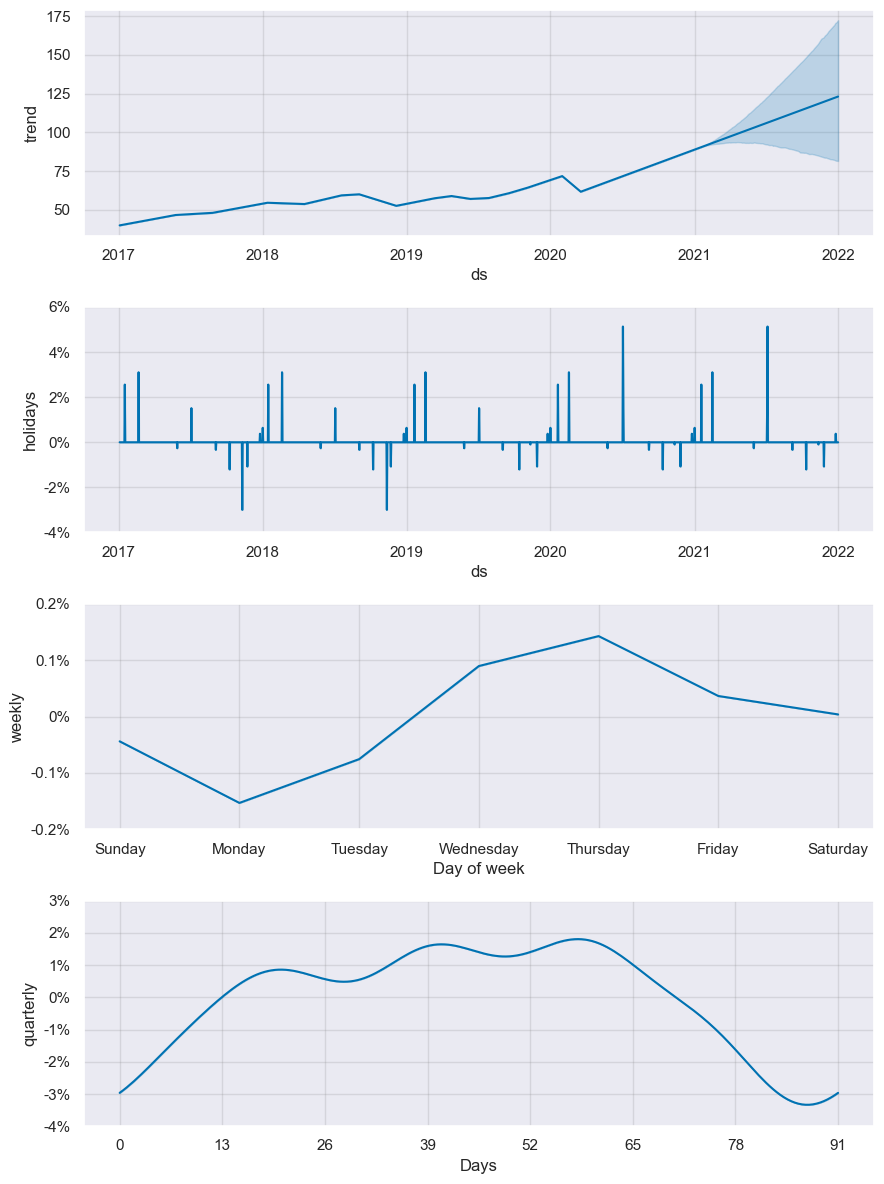

In [166]:
_ = model.plot_components(forecast)

# Cross-validation

In [167]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools



In [168]:
train_df.tail()

,ds,y
1459,2021-01-01,87.632004
1460,2021-01-02,87.632004
1461,2021-01-03,87.632004
1462,2021-01-04,86.306503
1463,2021-01-05,87.002502


In [169]:
cutoffs = pd.to_datetime(['2018-06-01', '2019-01-01', '2019-06-01'])

param_grid = {
    'seasonality_prior_scale': [0.5, 1.0, 10.0],
    'holidays_prior_scale':[10, 20, 50]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params, seasonality_mode='multiplicative',
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    holidays=holidays)
    model.add_seasonality(name='quarterly',
                      period=365.25/4,
                      fourier_order=5)
    model.fit(train_df)  # Fit model with given params
    df_cv = cross_validation(model, cutoffs=cutoffs, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

14:18:09 - cmdstanpy - INFO - Chain [1] start processing
14:18:09 - cmdstanpy - INFO - Chain [1] done processing
14:18:11 - cmdstanpy - INFO - Chain [1] start processing
14:18:11 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:14 - cmdstanpy - INFO - Chain [1] done processing
14:18:15 - cmdstanpy - INFO - Chain [1] start processing
14:18:16 - cmdstanpy - INFO - Chain [1] done processing
14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing
14:18:20 - cmdstanpy - INFO - Chain [1] start processing
14:18:20 - cmdstanpy - INFO - Chain [1] done processing
14:18:22 - cmdstanpy - INFO - Chain [1] start processing
14:18:22 - cmdstanpy - INFO - Chain [1] done processing
14:18:24 - cmdstanpy - INFO - Chain [1] start processing
14:18:24 - cmdstanpy - INFO - Chain [1] done processing
14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1]

   seasonality_prior_scale  holidays_prior_scale      mape
0                      0.5                    10  0.161175
1                      0.5                    20  0.160886
2                      0.5                    50  0.161305
3                      1.0                    10  0.161105
4                      1.0                    20  0.162114
5                      1.0                    50  0.161003
6                     10.0                    10  0.161951
7                     10.0                    20  0.162094
8                     10.0                    50  0.162370


In [170]:
tuning_results.sort_values(by='mape', ascending=True, inplace=True)

In [171]:
tuning_results

,seasonality_prior_scale,holidays_prior_scale,mape
1,0.5,20,0.160886
5,1.0,50,0.161003
3,1.0,10,0.161105
0,0.5,10,0.161175
2,0.5,50,0.161305
6,10.0,10,0.161951
7,10.0,20,0.162094
4,1.0,20,0.162114
8,10.0,50,0.162370


In [172]:
best_params=tuning_results.iloc[0][0:3]

In [173]:
best_params

seasonality_prior_scale     0.500000
holidays_prior_scale       20.000000
mape                        0.160886
Name: 1, dtype: float64

# Cделаем прогноз на тесте по лучшей модели

In [174]:
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, yearly_seasonality=False,
                holidays=holidays,
                seasonality_prior_scale=0.5,
                holidays_prior_scale=20)


#добавляем квартальную сезонность (данные финансовые)
model.add_seasonality(name='quarterly',
                      period=365.25/4,
                      fourier_order=5)

predictions=365

model.fit(train_df)


future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 14.10%


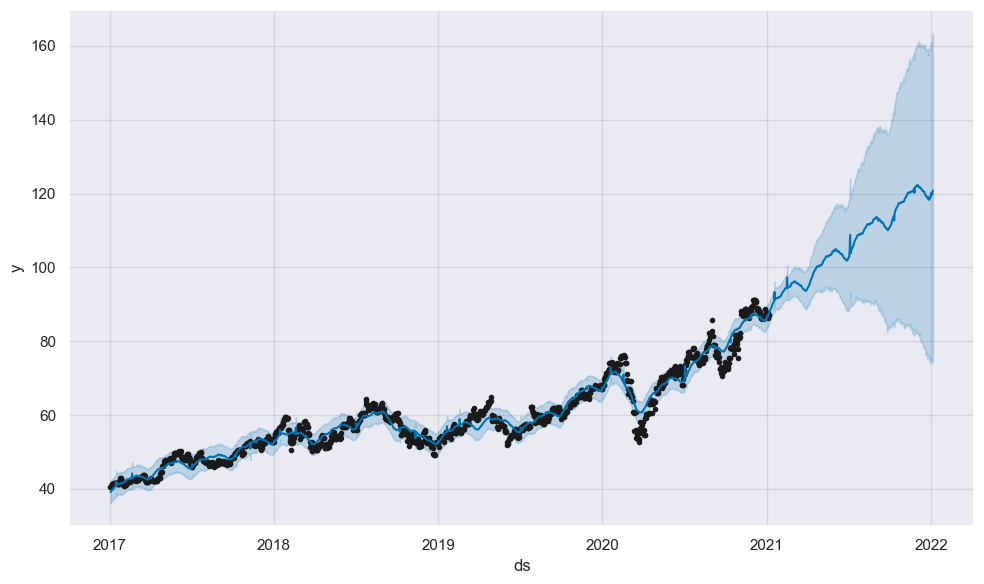

In [175]:
error = mean_absolute_percentage_error(data[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

лучшей все равно оказалась модель с параметрами, рассмотренными до кроссвалидации:
seasonality_prior_scale=0.5, holidays_prior_scale=50

# Прогноз на год

In [176]:
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, yearly_seasonality=False,
                holidays=holidays,
                seasonality_prior_scale=0.5,
                holidays_prior_scale=50)


model.add_seasonality(name='quarterly',
                      period=365.25 / 4,
                      fourier_order=5)

predictions=365

model.fit(data)


future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

14:18:29 - cmdstanpy - INFO - Chain [1] start processing
14:18:30 - cmdstanpy - INFO - Chain [1] done processing


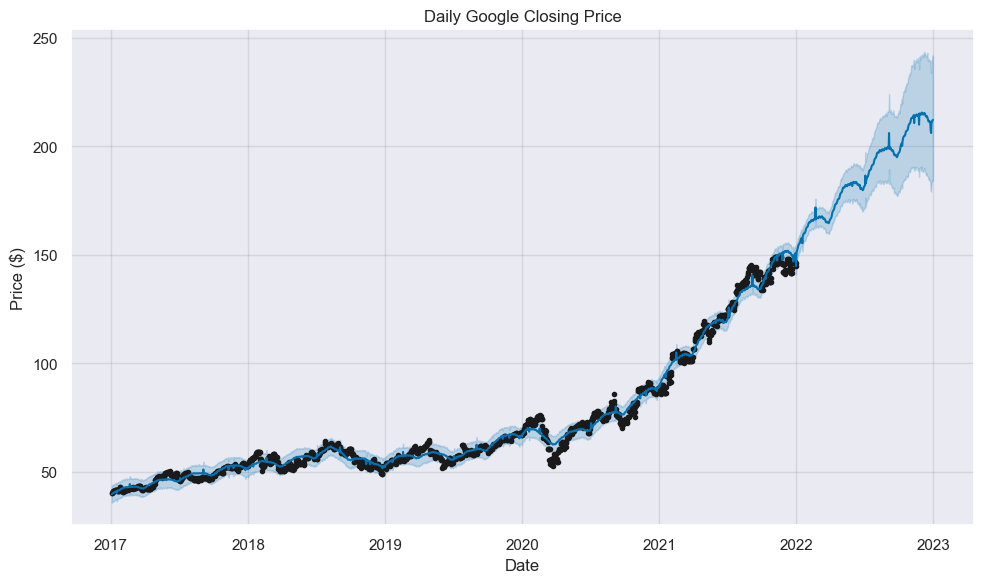

In [177]:
fig = model.plot(forecast, xlabel='Date',
                 ylabel='Price ($)')
plt.title('Daily Google Closing Price')
plt.show()

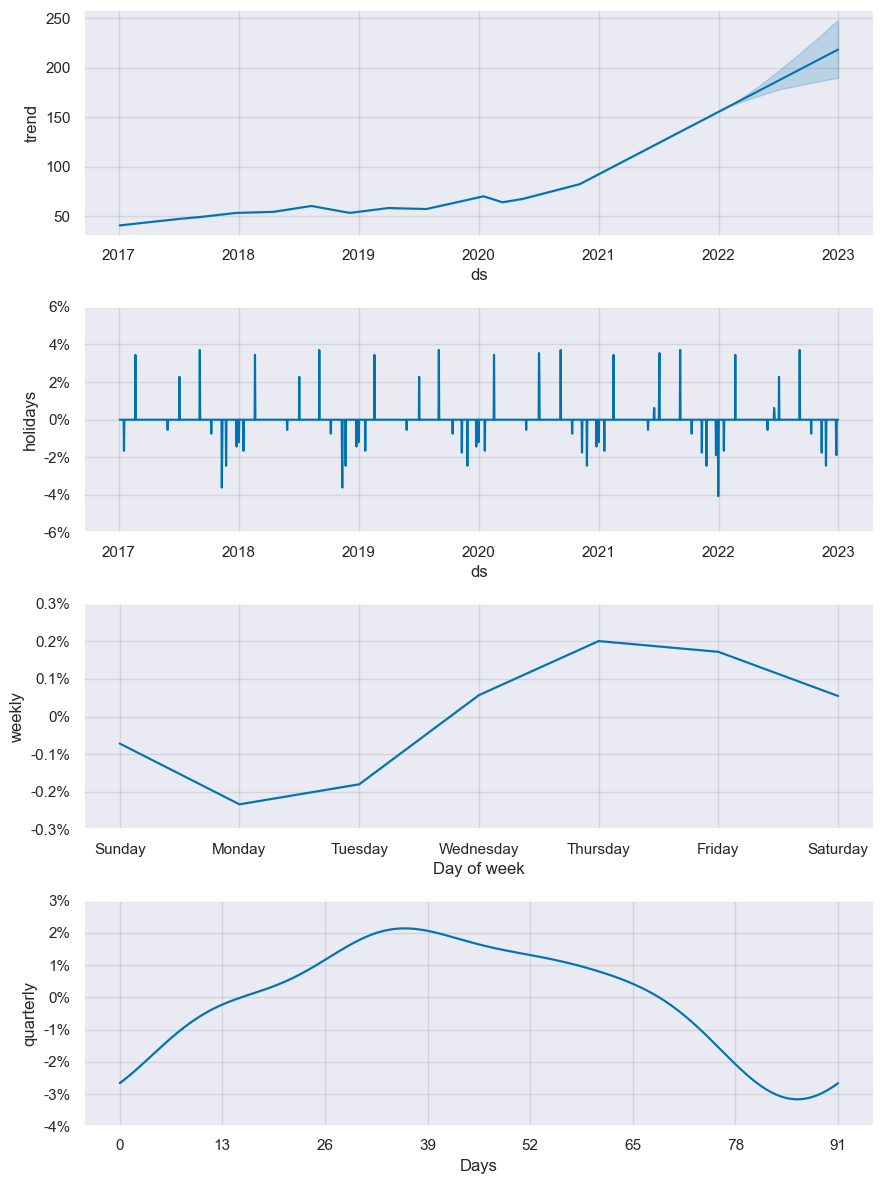

In [178]:
_ = model.plot_components(forecast)

# Выводы

Для прогнозирования цен закрытия компании Google c 2017 по 2022 на следующий год было проверено две модели: ARIMA(0,1,1) и Prophet.
Модель ARIMA не справилась с поставленной задачей, вероятнее всего так как не смогла отследить наличие недельной сезонности в данных, важным фактором так же оказалась квартальная сезонность и наличие праздников.
Модель Prophet справилась с этой задачей лучше в виду более гибких настроек сезонных составляющих. Ошибку на тестовой выборке уменьшить ниже 13,97% не удалось.